In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/daicwoz/GoogleNews-vectors-negative300.bin
/kaggle/input/daicwoz/daicwoz/daicwoz/379_COVAREP.csv
/kaggle/input/daicwoz/daicwoz/daicwoz/486_CLNF_hog.bin
/kaggle/input/daicwoz/daicwoz/daicwoz/424_CLNF_features.txt
/kaggle/input/daicwoz/daicwoz/daicwoz/388_CLNF_hog.bin
/kaggle/input/daicwoz/daicwoz/daicwoz/468_CLNF_pose.txt
/kaggle/input/daicwoz/daicwoz/daicwoz/427_FORMANT.csv
/kaggle/input/daicwoz/daicwoz/daicwoz/470_CLNF_AUs.txt
/kaggle/input/daicwoz/daicwoz/daicwoz/440_CLNF_features3D.txt
/kaggle/input/daicwoz/daicwoz/daicwoz/483_CLNF_gaze.txt
/kaggle/input/daicwoz/daicwoz/daicwoz/474_CLNF_hog.bin
/kaggle/input/daicwoz/daicwoz/daicwoz/481_CLNF_features.txt
/kaggle/input/daicwoz/daicwoz/daicwoz/408_CLNF_features.txt
/kaggle/input/daicwoz/daicwoz/daicwoz/391_CLNF_hog.bin
/kaggle/input/daicwoz/daicwoz/daicwoz/320_CLNF_pose.txt
/kaggle/input/daicwoz/daicwoz/daicwoz/318_CLNF_features3D.txt
/kaggle/input/daicwoz/daicwoz/daicwoz/test_split_Depression_AVEC2017.csv
/kaggle/input/d

# **Separating and Saving Transcripts as CSVs**

In [ ]:
import os
import shutil
import pandas as pd

# Create output directory
output_dir = '/kaggle/working/transcripts-4/'
os.makedirs(output_dir, exist_ok=True)

# Function to find and copy transcripts
def separate_transcripts(input_dir='/kaggle/input/daicwoz/daicwoz/daicwoz'):
    transcript_files = []
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file.endswith('_TRANSCRIPT.csv'):
                src_path = os.path.join(root, file)
                participant_id = file.split('_')[0]  # e.g., '300' from '300_TRANSCRIPT.csv'
                dest_path = os.path.join(output_dir, f'{participant_id}.csv')
                
                # Read tab-separated and save as comma-separated
                df = pd.read_csv(src_path, sep='\t')
                df.to_csv(dest_path, index=False)
                
                transcript_files.append(dest_path)
    return transcript_files

# Run separation
transcripts = separate_transcripts()
print(f'Separated and saved {len(transcripts)} transcript CSVs.')

# Visualize: Plot number of transcripts (simple bar for count)
import matplotlib.pyplot as plt
plt.bar(['Transcripts'], [len(transcripts)])
plt.title('Number of Separated Transcripts')
plt.show()

In [ ]:
def measure_csv_space(dir_path=output_dir):
    total_size = 0
    for file in os.listdir(dir_path):
        if file.endswith('.csv'):
            total_size += os.path.getsize(os.path.join(dir_path, file))
    total_mb = total_size / (1024 * 1024)
    print(f'Total space for CSVs: {total_mb:.2f} MB')
    return total_mb

# Run measurement
space = measure_csv_space()

# Visualize: Simple pie chart (space used vs. arbitrary free space for demo)
plt.pie([space, 100 - space], labels=['Used (MB)', 'Free'], autopct='%1.1f%%')
plt.title('CSV Space Usage (Demo Scale)')
plt.show()

# **Preprocessing Text Data**

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
import re
from wordcloud import WordCloud

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load labels (combine train/dev/test for full processing; adjust paths)
label_files = [
    '/kaggle/input/daicwoz/daicwoz/daicwoz/train_split_Depression_AVEC2017.csv',
    '/kaggle/input/daicwoz/daicwoz/daicwoz/dev_split_Depression_AVEC2017.csv',
    '/kaggle/input/daicwoz/daicwoz/daicwoz/test_split_Depression_AVEC2017.csv'
]
labels = pd.concat([pd.read_csv(f) for f in label_files if os.path.exists(f)], ignore_index=True)
labels = labels[['Participant_ID', 'PHQ8_Binary']]  # Focus on ID and binary label

# Preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)  # Remove punctuation
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize
    return ' '.join(tokens)

# Process all transcripts
processed_data = []
for csv in os.listdir(output_dir):
    if csv.endswith('.csv'):
        participant_id = int(csv.split('.')[0])
        df = pd.read_csv(os.path.join(output_dir, csv))
        participant_text = ' '.join(df[df['speaker'] == 'Participant']['value'].fillna('').astype(str))
        
        # Before preprocessing visualization: Word cloud
        if participant_text:
            wc_before = WordCloud(width=800, height=400).generate(participant_text)
            plt.figure(figsize=(10, 5))
            plt.imshow(wc_before, interpolation='bilinear')
            plt.title(f'Word Cloud Before Preprocessing (ID: {participant_id})')
            plt.axis('off')
            plt.show()
        
        cleaned_text = preprocess_text(participant_text)
        
        # After preprocessing visualization: Word cloud
        if cleaned_text:
            wc_after = WordCloud(width=800, height=400).generate(cleaned_text)
            plt.figure(figsize=(10, 5))
            plt.imshow(wc_after, interpolation='bilinear')
            plt.title(f'Word Cloud After Preprocessing (ID: {participant_id})')
            plt.axis('off')
            plt.show()
        
        # Histogram of word lengths before/after
        words_before = word_tokenize(participant_text)
        lengths_before = [len(word) for word in words_before]
        plt.hist(lengths_before, bins=20, alpha=0.5, label='Before')
        
        words_after = word_tokenize(cleaned_text)
        lengths_after = [len(word) for word in words_after]
        plt.hist(lengths_after, bins=20, alpha=0.5, label='After')
        plt.title(f'Word Length Distribution (ID: {participant_id})')
        plt.legend()
        plt.show()
        
        label = labels[labels['Participant_ID'] == participant_id]['PHQ8_Binary'].values[0] if participant_id in labels['Participant_ID'].values else None
        processed_data.append({'id': participant_id, 'text': cleaned_text, 'label': label})

# Save processed data
processed_df = pd.DataFrame(processed_data)
processed_df.to_csv('/kaggle/working/processed_data_mai.csv', index=False)

# **Feature Extraction**

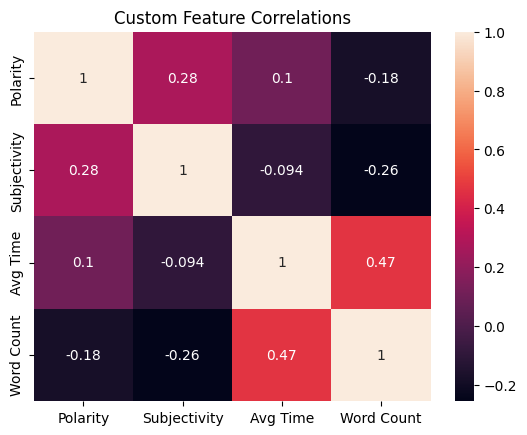

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
import numpy as np

# Load processed data
df = pd.read_csv('/kaggle/working/processed_data_mai.csv')
df = df.dropna(subset=['label'])  # Drop if no label

# TF-IDF features
vectorizer = TfidfVectorizer(max_features=500)  # Limit for simplicity
tfidf_features = vectorizer.fit_transform(df['text']).toarray()

# Additional features: sentiment, word count, avg response time
features = []
for idx, row in df.iterrows():
    participant_id = row['id']
    transcript_path = os.path.join(output_dir, f'{participant_id}.csv')
    trans_df = pd.read_csv(transcript_path)
    part_df = trans_df[trans_df['speaker'] == 'Participant']
    
    # Avg response time
    response_times = (part_df['stop_time'] - part_df['start_time']).values
    avg_time = np.mean(response_times) if len(response_times) > 0 else 0
    
    # Sentiment
    blob = TextBlob(row['text'])
    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity
    
    # Word count
    word_count = len(word_tokenize(row['text']))
    
    features.append([polarity, subjectivity, avg_time, word_count])

# Combine TF-IDF with custom features
custom_features = np.array(features)
all_features = np.hstack((tfidf_features, custom_features))

# Visualize: Feature correlation heatmap (sample)
import seaborn as sns
feat_df = pd.DataFrame(custom_features, columns=['Polarity', 'Subjectivity', 'Avg Time', 'Word Count'])
sns.heatmap(feat_df.corr(), annot=True)
plt.title('Custom Feature Correlations')
plt.show()

# Save features
np.save('/kaggle/working/features-2.npy', all_features)
df[['id', 'label']].to_csv('/kaggle/working/labels-2.csv', index=False)

# **Stratified K-Fold Ensemble: DistilBERT + BERT + RoBERTa**

In [5]:
# ================================
# Ensemble (fixed) + history logging + plotting + cleanup (keeps only best fold checkpoint per model)
# Saves PNGs: classification_report.png, confusion_matrix.png, roc_curve.png,
# and train_val_curve_<modelname>.png in OUTPUT_DIR.
# ================================

# !pip install -q transformers datasets evaluate accelerate sentencepiece

import os, json, random, math, gc
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup

# ---------- CONFIG ----------
CSV_CANDIDATES = ["/kaggle/working/processed_data_mai.csv", "/mnt/data/processed_data_main.csv"]
CSV_PATH = next((p for p in CSV_CANDIDATES if os.path.exists(p)), None)
if CSV_PATH is None:
    raise FileNotFoundError("processed_data_main.csv not found in expected paths")

OUTPUT_DIR = "/kaggle/working/ensemble-bert-final-4.2"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Ensemble / training config (tweak for speed / memory)
MODEL_NAMES = ["distilbert-base-uncased", "bert-base-uncased", "roberta-base"]  # ensemble members
FOLDS = 5                     # recommended for Kaggle T4; set to 5 only if you have time
SEED = 42
EPOCHS = 50                    # increase if you have time, but watch storage/time
BATCH_SIZE = 8                # reduce to 4 if OOM
ACCUM_STEPS = 2               # gradient accumulation to emulate larger batch
MAX_LEN = 256                 # reduce OOM; increase to 512 if you can
LR = 2e-5
WARMUP_PROPORTION = 0.06
GAMMA = 2.0                   # focal loss gamma

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---------- HELPERS ----------
def seed_everything(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def focal_loss(logits, targets, alpha=None, gamma=2.0, reduction='mean'):
    import torch.nn.functional as F
    ce = F.cross_entropy(logits, targets, reduction='none')
    pt = torch.exp(-ce)
    if alpha is not None:
        at = alpha[targets]
        ce = ce * at
    loss = ((1 - pt) ** gamma) * ce
    if reduction == 'mean':
        return loss.mean()
    elif reduction == 'sum':
        return loss.sum()
    else:
        return loss

def build_dataset_from_texts(texts, labels, tokenizer, max_len):
    enc = tokenizer(texts.tolist(), truncation=True, padding='max_length', max_length=max_len, return_tensors='pt')
    input_ids = enc['input_ids']
    attn_mask = enc['attention_mask']
    token_type_ids = enc['token_type_ids'] if "token_type_ids" in enc else None
    labels_t = torch.tensor(labels.values, dtype=torch.long)
    if token_type_ids is not None:
        dataset = TensorDataset(input_ids, attn_mask, token_type_ids, labels_t)
    else:
        dataset = TensorDataset(input_ids, attn_mask, labels_t)
    return dataset

def get_loader(dataset, sampler=None, batch_size=8, shuffle=False):
    return DataLoader(dataset, sampler=sampler, batch_size=batch_size, shuffle=(sampler is None and shuffle))

def evaluate_model(model, loader):
    model.eval()
    probs_list, labs = [], []
    with torch.no_grad():
        for batch in loader:
            batch = [b.to(device) for b in batch]
            if len(batch) == 4:
                input_ids, attn_mask, token_type_ids, labels = batch
                logits = model(input_ids=input_ids, attention_mask=attn_mask, token_type_ids=token_type_ids).logits
            else:
                input_ids, attn_mask, labels = batch
                logits = model(input_ids=input_ids, attention_mask=attn_mask).logits
            probs = torch.softmax(logits, dim=-1).cpu().numpy()
            probs_list.append(probs)
            labs.append(labels.cpu().numpy())
    probs_all = np.vstack(probs_list)
    labs_all = np.concatenate(labs) if len(labs) > 0 else np.array([])
    pred_labels = probs_all.argmax(axis=1)
    return probs_all, pred_labels, labs_all

# ---------- LOAD DATA ----------
seed_everything()
df = pd.read_csv(CSV_PATH)
if "text" not in df.columns or "label" not in df.columns:
    raise ValueError("CSV must contain 'text' and 'label' columns")
df = df[df['label'].isin([0,1])].reset_index(drop=True)
df['text'] = df['text'].astype(str)
df['label'] = df['label'].astype(int)
print("Dataset shape:", df.shape)
print(df['label'].value_counts())

# final hold-out test split (one-time)
trainval_df, test_df = train_test_split(df, test_size=0.15, stratify=df['label'], random_state=SEED)
print("Train+Val:", trainval_df.shape, "Test:", test_df.shape)

# storage for OOF probs (trainval)
oof_probs = np.zeros((len(trainval_df), 2), dtype=np.float32)

# Keep record of best fold per model (and its val_f1) so we can delete other fold checkpoints afterwards
saved_best_ckpts = {}  # model_name -> {"fold":k, "ckpt":path, "val_f1":v, "history":history_dict}

# ---------- K-FOLD TRAINING & saving history ----------
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

for model_name in MODEL_NAMES:
    print("\n======== MODEL:", model_name, "========")
    model_dir = os.path.join(OUTPUT_DIR, model_name.replace('/', '_'))
    os.makedirs(model_dir, exist_ok=True)
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

    fold_idx = 0
    # per-model list to later choose best fold
    per_model_fold_info = []  # list of dicts: {"fold":i, "ckpt":path, "val_f1":v, "history":history}

    for train_idx, val_idx in skf.split(trainval_df['text'], trainval_df['label']):
        fold_idx += 1
        print(f"\n--- Fold {fold_idx}/{FOLDS} for {model_name} ---")
        seed_everything(SEED + fold_idx)

        tr_texts = trainval_df.iloc[train_idx]['text'].reset_index(drop=True)
        tr_labels = trainval_df.iloc[train_idx]['label'].reset_index(drop=True)
        vl_texts = trainval_df.iloc[val_idx]['text'].reset_index(drop=True)
        vl_labels = trainval_df.iloc[val_idx]['label'].reset_index(drop=True)

        # build datasets & loaders
        train_ds = build_dataset_from_texts(tr_texts, tr_labels, tokenizer, MAX_LEN)
        val_ds   = build_dataset_from_texts(vl_texts, vl_labels, tokenizer, MAX_LEN)
        test_ds  = build_dataset_from_texts(test_df['text'].reset_index(drop=True), test_df['label'].reset_index(drop=True), tokenizer, MAX_LEN)

        # weighted sampler on train fold
        class_counts = tr_labels.value_counts().to_dict()
        sample_weights = tr_labels.map(lambda l: 1.0 / class_counts[l]).values
        sample_weights = torch.tensor(sample_weights, dtype=torch.double)
        weighted_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

        train_loader = get_loader(train_ds, sampler=weighted_sampler, batch_size=BATCH_SIZE)
        val_loader   = get_loader(val_ds, batch_size=BATCH_SIZE)
        test_loader  = get_loader(test_ds, batch_size=BATCH_SIZE)

        # model init
        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
        model.to(device)

        # class-balanced alpha for focal (per-fold)
        counts_arr = np.array([class_counts.get(i, 0) for i in range(2)])
        tot = counts_arr.sum()
        class_weights = tot / (2 * np.maximum(counts_arr, 1))
        alpha = torch.tensor(class_weights, dtype=torch.float).to(device)

        optimizer = AdamW(model.parameters(), lr=LR, weight_decay=0.01)
        total_steps = int(math.ceil(len(train_loader) * EPOCHS / ACCUM_STEPS))
        warmup_steps = int(total_steps * WARMUP_PROPORTION)
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

        scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

        # per-epoch history
        history = {"train_loss": [], "val_f1": [], "val_precision": [], "val_recall": [], "val_acc": []}
        best_val_f1 = -1.0
        best_ckpt = None

        global_step = 0
        for epoch in range(1, EPOCHS + 1):
            model.train()
            losses = []
            pbar = tqdm(train_loader, desc=f"train {model_name} f{fold_idx} e{epoch}")
            optimizer.zero_grad()
            for step, batch in enumerate(pbar, start=1):
                batch = [b.to(device) for b in batch]
                if len(batch) == 4:
                    input_ids, attn_mask, token_type_ids, labels = batch
                    kwargs = {'token_type_ids': token_type_ids}
                else:
                    input_ids, attn_mask, labels = batch
                    kwargs = {}

                with torch.cuda.amp.autocast(enabled=(scaler is not None)):
                    logits = model(input_ids=input_ids, attention_mask=attn_mask, **kwargs).logits
                    loss = focal_loss(logits, labels, alpha=alpha, gamma=GAMMA, reduction='mean')

                if scaler is not None:
                    scaler.scale(loss / ACCUM_STEPS).backward()
                else:
                    (loss / ACCUM_STEPS).backward()

                if step % ACCUM_STEPS == 0:
                    if scaler is not None:
                        scaler.unscale_(optimizer)
                        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                        scaler.step(optimizer)
                        scaler.update()
                    else:
                        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                        optimizer.step()
                    scheduler.step()
                    optimizer.zero_grad()
                    global_step += 1

                losses.append(loss.item())
                pbar.set_postfix(loss=np.mean(losses))

            # VAL
            val_probs, val_preds, val_labels_arr = evaluate_model(model, val_loader)
            val_acc = accuracy_score(val_labels_arr, val_preds)
            val_prec = precision_score(val_labels_arr, val_preds, zero_division=0)
            val_rec = recall_score(val_labels_arr, val_preds, zero_division=0)
            val_f1 = f1_score(val_labels_arr, val_preds, zero_division=0)

            history["train_loss"].append(float(np.mean(losses)) if len(losses) else None)
            history["val_f1"].append(float(val_f1))
            history["val_precision"].append(float(val_prec))
            history["val_recall"].append(float(val_rec))
            history["val_acc"].append(float(val_acc))

            print(f"Epoch {epoch} val -> acc {val_acc:.4f}, prec {val_prec:.4f}, rec {val_rec:.4f}, f1 {val_f1:.4f}")

            # if improved, save best fold checkpoint (overwrite previous best for this fold)
            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                # Save only model weights + tokenizer (HF default)
                ckpt_dir = os.path.join(model_dir, f"fold{fold_idx}")
                # remove previous ckpt for this fold to avoid duplicates (keep only latest best for fold)
                if os.path.isdir(ckpt_dir):
                    # clean old folder to keep only current best snapshot
                    for f in os.listdir(ckpt_dir):
                        pathf = os.path.join(ckpt_dir, f)
                        try:
                            if os.path.isfile(pathf):
                                os.remove(pathf)
                            else:
                                import shutil
                                shutil.rmtree(pathf)
                        except Exception:
                            pass
                os.makedirs(ckpt_dir, exist_ok=True)
                model.save_pretrained(ckpt_dir)
                tokenizer.save_pretrained(ckpt_dir)
                # save history for this fold at the best-checkpoint time (overwrite)
                with open(os.path.join(ckpt_dir, "history.json"), "w") as fh:
                    json.dump(history, fh)
                best_ckpt = ckpt_dir
                print("Saved best fold ckpt to:", ckpt_dir)

        # End epochs for fold
        # record info for this fold
        per_model_fold_info.append({"fold": fold_idx, "ckpt": best_ckpt, "val_f1": float(best_val_f1), "history": history})

        # Evaluate best_ckpt model on val and test, save test probs for ensemble
        if best_ckpt is not None:
            best_model = AutoModelForSequenceClassification.from_pretrained(best_ckpt).to(device)
            val_probs_best, _, _ = evaluate_model(best_model, val_loader)
            test_probs_fold, _, _ = evaluate_model(best_model, test_loader)
            # save test probs for later ensemble
            test_probs_path = os.path.join(model_dir, f"test_probs_fold{fold_idx}.npy")
            np.save(test_probs_path, test_probs_fold.astype(np.float32))
            print("Saved test probs for fold to:", test_probs_path)
            # add validation probs into oof-probs accumulator at correct indices
            # val_idx is positional indices into trainval_df, so align:
            oof_probs[val_idx] += val_probs_best
            # free loaded model
            del best_model
            torch.cuda.empty_cache()
        else:
            print("Warning: No best checkpoint saved for this fold (no improvement occurred)")

        # delete training model to free memory
        del model
        torch.cuda.empty_cache()
        gc.collect()

    # choose the best fold for this model (highest val_f1)
    best_fold_info = max([f for f in per_model_fold_info if f["ckpt"] is not None], key=lambda x: x["val_f1"], default=None)
    if best_fold_info is None:
        print(f"Warning: no valid best fold found for model {model_name}. Skipping saving best-fold-only policy.")
        # fallback: keep all fold ckpts for this model_dir (but this risks storage)
    else:
        # record chosen best fold ckpt details
        saved_best_ckpts[model_name] = {
            "fold": int(best_fold_info["fold"]),
            "ckpt": best_fold_info["ckpt"],
            "val_f1": float(best_fold_info["val_f1"]),
            "history": best_fold_info["history"]
        }
        # remove other fold checkpoint directories for this model to save space
        for f in os.listdir(model_dir):
            fpath = os.path.join(model_dir, f)
            if f.startswith("fold") and os.path.isdir(fpath):
                if fpath != best_fold_info["ckpt"]:
                    try:
                        import shutil
                        shutil.rmtree(fpath)
                        print("Removed non-best fold checkpoint to save space:", fpath)
                    except Exception as e:
                        print("Could not remove", fpath, e)

# ---------- End training for all models ----------
# At this point, we have oof_probs accumulated as SUM of contributions from each model-fold
total_model_fold_contribs = len(MODEL_NAMES) * FOLDS
oof_avg_probs = oof_probs / float(total_model_fold_contribs)
oof_pred_labels = np.argmax(oof_avg_probs, axis=1)
true_labels = trainval_df['label'].values

print("OOF ensemble metrics (on trainval):")
print("Acc:", accuracy_score(true_labels, oof_pred_labels))
print("Prec:", precision_score(true_labels, oof_pred_labels, zero_division=0))
print("Rec:", recall_score(true_labels, oof_pred_labels, zero_division=0))
print("F1:", f1_score(true_labels, oof_pred_labels, zero_division=0))
print("Confusion:\n", confusion_matrix(true_labels, oof_pred_labels))

# ---------- Build final test-time ensemble by averaging saved test_probs across all model-folds ----------
test_probs_paths = []
for model_name in MODEL_NAMES:
    model_dir = os.path.join(OUTPUT_DIR, model_name.replace('/', '_'))
    for fname in sorted(os.listdir(model_dir)):
        if fname.startswith("test_probs_fold") and fname.endswith(".npy"):
            test_probs_paths.append(os.path.join(model_dir, fname))

if len(test_probs_paths) == 0:
    raise RuntimeError("No test probs saved — something went wrong. Check model_dir contents.")

# load and average
probs_list = [np.load(p) for p in test_probs_paths]
test_probs_avg = np.mean(np.stack(probs_list, axis=0), axis=0)  # mean across contributions
test_pred_labels = np.argmax(test_probs_avg, axis=1)
test_true = test_df['label'].values

print("\nEnsemble TEST metrics:")
print("Acc:", accuracy_score(test_true, test_pred_labels))
print("Prec:", precision_score(test_true, test_pred_labels, zero_division=0))
print("Rec:", recall_score(test_true, test_pred_labels, zero_division=0))
print("F1:", f1_score(test_true, test_pred_labels, zero_division=0))
print("Confusion:\n", confusion_matrix(test_true, test_pred_labels))
print("Classification report:\n", classification_report(test_true, test_pred_labels, digits=4))

# Save ensemble test preds & metrics
out_df = test_df.reset_index(drop=True).copy()
out_df['pred'] = test_pred_labels
out_df.to_csv(os.path.join(OUTPUT_DIR, "ensemble_test_predictions.csv"), index=False)
with open(os.path.join(OUTPUT_DIR, "ensemble_test_metrics.json"), "w") as fh:
    json.dump({
        "acc": float(accuracy_score(test_true, test_pred_labels)),
        "precision": float(precision_score(test_true, test_pred_labels, zero_division=0)),
        "recall": float(recall_score(test_true, test_pred_labels, zero_division=0)),
        "f1": float(f1_score(test_true, test_pred_labels, zero_division=0))
    }, fh)

# ---------- PLOT & SAVE: classification report, confusion matrix, ROC ----------
# classification report text -> PNG
clf_report = classification_report(test_true, test_pred_labels, digits=4)
plt.figure(figsize=(8,6))
plt.axis('off')
plt.title("Classification Report (Ensemble Test)")
plt.text(0.01, 0.99, clf_report, fontsize=10, va='top', family='monospace')
plt.savefig(os.path.join(OUTPUT_DIR, "classification_report.png"), bbox_inches='tight', dpi=200)
plt.close()

# confusion matrix -> PNG
cm = confusion_matrix(test_true, test_pred_labels)
plt.figure(figsize=(5,5))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (Ensemble Test)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.colorbar()
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 verticalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.savefig(os.path.join(OUTPUT_DIR, "confusion_matrix.png"), bbox_inches='tight', dpi=200)
plt.close()

# ROC curve -> requires probabilities for positive class
try:
    # test_probs_avg shape (n_contribs, n_test, 2) averaged -> (n_test, 2) after mean
    if test_probs_avg.ndim == 2 and test_probs_avg.shape[1] == 2:
        pos_probs = test_probs_avg[:, 1]
        fpr, tpr, _ = roc_curve(test_true, pos_probs)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(6,6))
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
        plt.plot([0,1], [0,1], linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve (Ensemble Test)')
        plt.legend(loc='lower right')
        plt.savefig(os.path.join(OUTPUT_DIR, "roc_curve.png"), bbox_inches='tight', dpi=200)
        plt.close()
    else:
        print("Unexpected shape for test_probs_avg; skipping ROC.")
except Exception as e:
    print("ROC plotting failed:", e)

# ---------- PLOT & SAVE train/val curve for each model using saved best-fold history ----------
for model_name, info in saved_best_ckpts.items():
    ckpt_dir = info["ckpt"]
    hist_path = os.path.join(ckpt_dir, "history.json")
    if os.path.exists(hist_path):
        try:
            with open(hist_path, 'r') as fh:
                history = json.load(fh)
            # plot train_loss & val_f1
            epochs = list(range(1, 1 + max(len(history.get("train_loss", [])), len(history.get("val_f1", [])))))
            plt.figure(figsize=(8,5))
            if "train_loss" in history and len(history["train_loss"])>0:
                plt.plot(list(range(1,1+len(history["train_loss"]))), history["train_loss"], marker='o', label='train_loss')
            if "val_f1" in history and len(history["val_f1"])>0:
                plt.plot(list(range(1,1+len(history["val_f1"]))), history["val_f1"], marker='o', label='val_f1')
            plt.xlabel("Epoch")
            plt.title(f"Train loss & Val F1 ({model_name} best fold)")
            plt.legend()
            safe_name = model_name.replace('/', '_')
            plt.savefig(os.path.join(OUTPUT_DIR, f"train_val_curve_{safe_name}.png"), bbox_inches='tight', dpi=200)
            plt.close()
        except Exception as e:
            print("Could not plot history for", model_name, ":", e)
    else:
        print("No history.json for best fold of", model_name, "-> skipping train/val curve.")

# ---------- CLEANUP: remove per-fold test_probs .npy to save space (we already produced final averaged test_probs) ----------
for model_name in MODEL_NAMES:
    model_dir = os.path.join(OUTPUT_DIR, model_name.replace('/', '_'))
    for fname in sorted(os.listdir(model_dir)):
        if fname.startswith("test_probs_fold") and fname.endswith(".npy"):
            try:
                os.remove(os.path.join(model_dir, fname))
                print("Removed temporary test_probs file:", os.path.join(model_dir, fname))
            except Exception as e:
                print("Could not remove temporary file:", e)

# ---------- FINAL: Keep only one (best) checkpoint per model (already done) and save summary ----------
summary = {
    "models_kept": {},
    "ensemble_test_metrics": {
        "acc": float(accuracy_score(test_true, test_pred_labels)),
        "precision": float(precision_score(test_true, test_pred_labels, zero_division=0)),
        "recall": float(recall_score(test_true, test_pred_labels, zero_division=0)),
        "f1": float(f1_score(test_true, test_pred_labels, zero_division=0))
    }
}
for model_name, info in saved_best_ckpts.items():
    summary["models_kept"][model_name] = {
        "best_fold": info["fold"],
        "ckpt_dir": info["ckpt"],
        "val_f1": info["val_f1"]
    }
with open(os.path.join(OUTPUT_DIR, "ensemble_summary.json"), "w") as fh:
    json.dump(summary, fh)

print("\nDone. Outputs saved to:", OUTPUT_DIR)
print("Files: ")
print(os.listdir(OUTPUT_DIR))


Device: cuda
Dataset shape: (141, 3)
label
0    99
1    42
Name: count, dtype: int64
Train+Val: (119, 3) Test: (22, 3)

======== MODEL: distilbert-base-uncased ========

--- Fold 1/5 for distilbert-base-uncased ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_47/3659017164.py:177: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None


train distilbert-base-uncased f1 e1:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 1 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516
Saved best fold ckpt to: /kaggle/working/ensemble-bert-final-4.2/distilbert-base-uncased/fold1


train distilbert-base-uncased f1 e2:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 2 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train distilbert-base-uncased f1 e3:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 3 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train distilbert-base-uncased f1 e4:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 4 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train distilbert-base-uncased f1 e5:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 5 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train distilbert-base-uncased f1 e6:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 6 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train distilbert-base-uncased f1 e7:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 7 val -> acc 0.4167, prec 0.3333, rec 1.0000, f1 0.5000
Saved best fold ckpt to: /kaggle/working/ensemble-bert-final-4.2/distilbert-base-uncased/fold1


train distilbert-base-uncased f1 e8:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 8 val -> acc 0.5833, prec 0.3846, rec 0.7143, f1 0.5000


train distilbert-base-uncased f1 e9:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 9 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train distilbert-base-uncased f1 e10:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 10 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train distilbert-base-uncased f1 e11:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 11 val -> acc 0.5000, prec 0.3333, rec 0.7143, f1 0.4545


train distilbert-base-uncased f1 e12:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 12 val -> acc 0.5833, prec 0.0000, rec 0.0000, f1 0.0000


train distilbert-base-uncased f1 e13:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 13 val -> acc 0.2917, prec 0.2500, rec 0.7143, f1 0.3704


train distilbert-base-uncased f1 e14:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 14 val -> acc 0.5833, prec 0.2000, rec 0.1429, f1 0.1667


train distilbert-base-uncased f1 e15:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 15 val -> acc 0.4583, prec 0.1250, rec 0.1429, f1 0.1333


train distilbert-base-uncased f1 e16:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 16 val -> acc 0.5417, prec 0.0000, rec 0.0000, f1 0.0000


train distilbert-base-uncased f1 e17:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 17 val -> acc 0.5417, prec 0.1667, rec 0.1429, f1 0.1538


train distilbert-base-uncased f1 e18:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 18 val -> acc 0.5417, prec 0.1667, rec 0.1429, f1 0.1538


train distilbert-base-uncased f1 e19:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 19 val -> acc 0.5417, prec 0.1667, rec 0.1429, f1 0.1538


train distilbert-base-uncased f1 e20:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 20 val -> acc 0.6250, prec 0.0000, rec 0.0000, f1 0.0000


train distilbert-base-uncased f1 e21:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 21 val -> acc 0.6667, prec 0.0000, rec 0.0000, f1 0.0000


train distilbert-base-uncased f1 e22:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 22 val -> acc 0.5833, prec 0.0000, rec 0.0000, f1 0.0000


train distilbert-base-uncased f1 e23:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 23 val -> acc 0.5417, prec 0.1667, rec 0.1429, f1 0.1538


train distilbert-base-uncased f1 e24:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 24 val -> acc 0.5417, prec 0.1667, rec 0.1429, f1 0.1538


train distilbert-base-uncased f1 e25:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 25 val -> acc 0.5417, prec 0.1667, rec 0.1429, f1 0.1538


train distilbert-base-uncased f1 e26:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 26 val -> acc 0.5417, prec 0.1667, rec 0.1429, f1 0.1538


train distilbert-base-uncased f1 e27:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 27 val -> acc 0.5417, prec 0.1667, rec 0.1429, f1 0.1538


train distilbert-base-uncased f1 e28:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 28 val -> acc 0.5833, prec 0.0000, rec 0.0000, f1 0.0000


train distilbert-base-uncased f1 e29:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 29 val -> acc 0.6250, prec 0.0000, rec 0.0000, f1 0.0000


train distilbert-base-uncased f1 e30:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 30 val -> acc 0.5833, prec 0.0000, rec 0.0000, f1 0.0000


train distilbert-base-uncased f1 e31:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 31 val -> acc 0.5833, prec 0.2000, rec 0.1429, f1 0.1667


train distilbert-base-uncased f1 e32:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 32 val -> acc 0.5833, prec 0.2000, rec 0.1429, f1 0.1667


train distilbert-base-uncased f1 e33:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 33 val -> acc 0.5833, prec 0.2000, rec 0.1429, f1 0.1667


train distilbert-base-uncased f1 e34:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 34 val -> acc 0.5833, prec 0.2000, rec 0.1429, f1 0.1667


train distilbert-base-uncased f1 e35:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 35 val -> acc 0.5833, prec 0.2000, rec 0.1429, f1 0.1667


train distilbert-base-uncased f1 e36:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 36 val -> acc 0.5833, prec 0.2000, rec 0.1429, f1 0.1667


train distilbert-base-uncased f1 e37:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 37 val -> acc 0.5833, prec 0.2000, rec 0.1429, f1 0.1667


train distilbert-base-uncased f1 e38:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 38 val -> acc 0.5833, prec 0.2000, rec 0.1429, f1 0.1667


train distilbert-base-uncased f1 e39:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 39 val -> acc 0.5833, prec 0.2000, rec 0.1429, f1 0.1667


train distilbert-base-uncased f1 e40:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 40 val -> acc 0.5833, prec 0.2000, rec 0.1429, f1 0.1667


train distilbert-base-uncased f1 e41:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 41 val -> acc 0.5833, prec 0.2000, rec 0.1429, f1 0.1667


train distilbert-base-uncased f1 e42:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 42 val -> acc 0.5833, prec 0.2000, rec 0.1429, f1 0.1667


train distilbert-base-uncased f1 e43:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 43 val -> acc 0.5833, prec 0.2000, rec 0.1429, f1 0.1667


train distilbert-base-uncased f1 e44:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 44 val -> acc 0.5833, prec 0.2000, rec 0.1429, f1 0.1667


train distilbert-base-uncased f1 e45:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 45 val -> acc 0.5833, prec 0.2000, rec 0.1429, f1 0.1667


train distilbert-base-uncased f1 e46:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 46 val -> acc 0.5833, prec 0.2000, rec 0.1429, f1 0.1667


train distilbert-base-uncased f1 e47:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 47 val -> acc 0.5833, prec 0.2000, rec 0.1429, f1 0.1667


train distilbert-base-uncased f1 e48:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 48 val -> acc 0.5833, prec 0.2000, rec 0.1429, f1 0.1667


train distilbert-base-uncased f1 e49:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 49 val -> acc 0.5833, prec 0.2000, rec 0.1429, f1 0.1667


train distilbert-base-uncased f1 e50:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 50 val -> acc 0.5833, prec 0.2000, rec 0.1429, f1 0.1667
Saved test probs for fold to: /kaggle/working/ensemble-bert-final-4.2/distilbert-base-uncased/test_probs_fold1.npy

--- Fold 2/5 for distilbert-base-uncased ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_47/3659017164.py:177: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None


train distilbert-base-uncased f2 e1:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 1 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516
Saved best fold ckpt to: /kaggle/working/ensemble-bert-final-4.2/distilbert-base-uncased/fold2


train distilbert-base-uncased f2 e2:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 2 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train distilbert-base-uncased f2 e3:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 3 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train distilbert-base-uncased f2 e4:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 4 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train distilbert-base-uncased f2 e5:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 5 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train distilbert-base-uncased f2 e6:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 6 val -> acc 0.5833, prec 0.4118, rec 1.0000, f1 0.5833
Saved best fold ckpt to: /kaggle/working/ensemble-bert-final-4.2/distilbert-base-uncased/fold2


train distilbert-base-uncased f2 e7:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 7 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train distilbert-base-uncased f2 e8:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 8 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train distilbert-base-uncased f2 e9:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 9 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train distilbert-base-uncased f2 e10:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 10 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train distilbert-base-uncased f2 e11:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 11 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train distilbert-base-uncased f2 e12:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 12 val -> acc 0.3333, prec 0.3043, rec 1.0000, f1 0.4667


train distilbert-base-uncased f2 e13:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 13 val -> acc 0.4167, prec 0.3333, rec 1.0000, f1 0.5000


train distilbert-base-uncased f2 e14:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 14 val -> acc 0.3750, prec 0.3182, rec 1.0000, f1 0.4828


train distilbert-base-uncased f2 e15:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 15 val -> acc 0.6667, prec 0.4615, rec 0.8571, f1 0.6000
Saved best fold ckpt to: /kaggle/working/ensemble-bert-final-4.2/distilbert-base-uncased/fold2


train distilbert-base-uncased f2 e16:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 16 val -> acc 0.7083, prec 0.5000, rec 0.4286, f1 0.4615


train distilbert-base-uncased f2 e17:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 17 val -> acc 0.5000, prec 0.3684, rec 1.0000, f1 0.5385


train distilbert-base-uncased f2 e18:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 18 val -> acc 0.8333, prec 0.8000, rec 0.5714, f1 0.6667
Saved best fold ckpt to: /kaggle/working/ensemble-bert-final-4.2/distilbert-base-uncased/fold2


train distilbert-base-uncased f2 e19:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 19 val -> acc 0.6667, prec 0.4545, rec 0.7143, f1 0.5556


train distilbert-base-uncased f2 e20:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 20 val -> acc 0.6667, prec 0.4545, rec 0.7143, f1 0.5556


train distilbert-base-uncased f2 e21:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 21 val -> acc 0.7083, prec 0.5000, rec 0.7143, f1 0.5882


train distilbert-base-uncased f2 e22:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 22 val -> acc 0.7500, prec 0.5455, rec 0.8571, f1 0.6667


train distilbert-base-uncased f2 e23:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 23 val -> acc 0.7500, prec 0.5714, rec 0.5714, f1 0.5714


train distilbert-base-uncased f2 e24:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 24 val -> acc 0.7083, prec 0.5000, rec 0.4286, f1 0.4615


train distilbert-base-uncased f2 e25:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 25 val -> acc 0.6667, prec 0.4286, rec 0.4286, f1 0.4286


train distilbert-base-uncased f2 e26:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 26 val -> acc 0.7083, prec 0.5000, rec 0.4286, f1 0.4615


train distilbert-base-uncased f2 e27:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 27 val -> acc 0.7083, prec 0.5000, rec 0.4286, f1 0.4615


train distilbert-base-uncased f2 e28:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 28 val -> acc 0.7083, prec 0.5000, rec 0.4286, f1 0.4615


train distilbert-base-uncased f2 e29:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 29 val -> acc 0.7083, prec 0.5000, rec 0.4286, f1 0.4615


train distilbert-base-uncased f2 e30:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 30 val -> acc 0.6667, prec 0.4286, rec 0.4286, f1 0.4286


train distilbert-base-uncased f2 e31:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 31 val -> acc 0.7083, prec 0.5000, rec 0.4286, f1 0.4615


train distilbert-base-uncased f2 e32:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 32 val -> acc 0.7083, prec 0.5000, rec 0.4286, f1 0.4615


train distilbert-base-uncased f2 e33:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 33 val -> acc 0.7083, prec 0.5000, rec 0.4286, f1 0.4615


train distilbert-base-uncased f2 e34:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 34 val -> acc 0.7083, prec 0.5000, rec 0.4286, f1 0.4615


train distilbert-base-uncased f2 e35:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 35 val -> acc 0.7083, prec 0.5000, rec 0.4286, f1 0.4615


train distilbert-base-uncased f2 e36:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 36 val -> acc 0.7083, prec 0.5000, rec 0.4286, f1 0.4615


train distilbert-base-uncased f2 e37:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 37 val -> acc 0.7083, prec 0.5000, rec 0.4286, f1 0.4615


train distilbert-base-uncased f2 e38:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 38 val -> acc 0.7083, prec 0.5000, rec 0.4286, f1 0.4615


train distilbert-base-uncased f2 e39:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 39 val -> acc 0.7083, prec 0.5000, rec 0.4286, f1 0.4615


train distilbert-base-uncased f2 e40:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 40 val -> acc 0.7083, prec 0.5000, rec 0.4286, f1 0.4615


train distilbert-base-uncased f2 e41:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 41 val -> acc 0.7083, prec 0.5000, rec 0.4286, f1 0.4615


train distilbert-base-uncased f2 e42:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 42 val -> acc 0.7083, prec 0.5000, rec 0.4286, f1 0.4615


train distilbert-base-uncased f2 e43:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 43 val -> acc 0.7083, prec 0.5000, rec 0.4286, f1 0.4615


train distilbert-base-uncased f2 e44:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 44 val -> acc 0.7083, prec 0.5000, rec 0.4286, f1 0.4615


train distilbert-base-uncased f2 e45:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 45 val -> acc 0.7083, prec 0.5000, rec 0.4286, f1 0.4615


train distilbert-base-uncased f2 e46:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 46 val -> acc 0.7083, prec 0.5000, rec 0.4286, f1 0.4615


train distilbert-base-uncased f2 e47:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 47 val -> acc 0.7083, prec 0.5000, rec 0.4286, f1 0.4615


train distilbert-base-uncased f2 e48:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 48 val -> acc 0.7083, prec 0.5000, rec 0.4286, f1 0.4615


train distilbert-base-uncased f2 e49:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 49 val -> acc 0.7083, prec 0.5000, rec 0.4286, f1 0.4615


train distilbert-base-uncased f2 e50:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 50 val -> acc 0.7083, prec 0.5000, rec 0.4286, f1 0.4615
Saved test probs for fold to: /kaggle/working/ensemble-bert-final-4.2/distilbert-base-uncased/test_probs_fold2.npy

--- Fold 3/5 for distilbert-base-uncased ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_47/3659017164.py:177: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None


train distilbert-base-uncased f3 e1:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 1 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516
Saved best fold ckpt to: /kaggle/working/ensemble-bert-final-4.2/distilbert-base-uncased/fold3


train distilbert-base-uncased f3 e2:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 2 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train distilbert-base-uncased f3 e3:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 3 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train distilbert-base-uncased f3 e4:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 4 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train distilbert-base-uncased f3 e5:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 5 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train distilbert-base-uncased f3 e6:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 6 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train distilbert-base-uncased f3 e7:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 7 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train distilbert-base-uncased f3 e8:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 8 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train distilbert-base-uncased f3 e9:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 9 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train distilbert-base-uncased f3 e10:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 10 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train distilbert-base-uncased f3 e11:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 11 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train distilbert-base-uncased f3 e12:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 12 val -> acc 0.3750, prec 0.2500, rec 0.5714, f1 0.3478


train distilbert-base-uncased f3 e13:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 13 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train distilbert-base-uncased f3 e14:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 14 val -> acc 0.5833, prec 0.2000, rec 0.1429, f1 0.1667


train distilbert-base-uncased f3 e15:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 15 val -> acc 0.4583, prec 0.3500, rec 1.0000, f1 0.5185
Saved best fold ckpt to: /kaggle/working/ensemble-bert-final-4.2/distilbert-base-uncased/fold3


train distilbert-base-uncased f3 e16:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 16 val -> acc 0.7083, prec 0.5000, rec 0.1429, f1 0.2222


train distilbert-base-uncased f3 e17:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 17 val -> acc 0.4583, prec 0.2500, rec 0.4286, f1 0.3158


train distilbert-base-uncased f3 e18:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 18 val -> acc 0.7500, prec 0.6667, rec 0.2857, f1 0.4000


train distilbert-base-uncased f3 e19:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 19 val -> acc 0.5417, prec 0.3000, rec 0.4286, f1 0.3529


train distilbert-base-uncased f3 e20:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 20 val -> acc 0.7083, prec 0.5000, rec 0.2857, f1 0.3636


train distilbert-base-uncased f3 e21:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 21 val -> acc 0.4167, prec 0.2308, rec 0.4286, f1 0.3000


train distilbert-base-uncased f3 e22:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 22 val -> acc 0.7083, prec 0.5000, rec 0.2857, f1 0.3636


train distilbert-base-uncased f3 e23:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 23 val -> acc 0.5417, prec 0.3000, rec 0.4286, f1 0.3529


train distilbert-base-uncased f3 e24:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 24 val -> acc 0.5417, prec 0.3000, rec 0.4286, f1 0.3529


train distilbert-base-uncased f3 e25:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 25 val -> acc 0.7083, prec 0.5000, rec 0.2857, f1 0.3636


train distilbert-base-uncased f3 e26:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 26 val -> acc 0.7083, prec 0.5000, rec 0.2857, f1 0.3636


train distilbert-base-uncased f3 e27:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 27 val -> acc 0.7083, prec 0.5000, rec 0.2857, f1 0.3636


train distilbert-base-uncased f3 e28:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 28 val -> acc 0.7083, prec 0.5000, rec 0.2857, f1 0.3636


train distilbert-base-uncased f3 e29:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 29 val -> acc 0.5833, prec 0.2857, rec 0.2857, f1 0.2857


train distilbert-base-uncased f3 e30:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 30 val -> acc 0.5417, prec 0.2500, rec 0.2857, f1 0.2667


train distilbert-base-uncased f3 e31:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 31 val -> acc 0.7083, prec 0.5000, rec 0.2857, f1 0.3636


train distilbert-base-uncased f3 e32:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 32 val -> acc 0.7083, prec 0.5000, rec 0.2857, f1 0.3636


train distilbert-base-uncased f3 e33:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 33 val -> acc 0.7083, prec 0.5000, rec 0.2857, f1 0.3636


train distilbert-base-uncased f3 e34:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 34 val -> acc 0.7083, prec 0.5000, rec 0.2857, f1 0.3636


train distilbert-base-uncased f3 e35:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 35 val -> acc 0.7083, prec 0.5000, rec 0.2857, f1 0.3636


train distilbert-base-uncased f3 e36:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 36 val -> acc 0.7083, prec 0.5000, rec 0.2857, f1 0.3636


train distilbert-base-uncased f3 e37:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 37 val -> acc 0.7083, prec 0.5000, rec 0.2857, f1 0.3636


train distilbert-base-uncased f3 e38:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 38 val -> acc 0.7083, prec 0.5000, rec 0.2857, f1 0.3636


train distilbert-base-uncased f3 e39:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 39 val -> acc 0.7083, prec 0.5000, rec 0.2857, f1 0.3636


train distilbert-base-uncased f3 e40:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 40 val -> acc 0.7083, prec 0.5000, rec 0.2857, f1 0.3636


train distilbert-base-uncased f3 e41:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 41 val -> acc 0.7083, prec 0.5000, rec 0.2857, f1 0.3636


train distilbert-base-uncased f3 e42:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 42 val -> acc 0.7083, prec 0.5000, rec 0.2857, f1 0.3636


train distilbert-base-uncased f3 e43:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 43 val -> acc 0.7083, prec 0.5000, rec 0.2857, f1 0.3636


train distilbert-base-uncased f3 e44:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 44 val -> acc 0.7083, prec 0.5000, rec 0.2857, f1 0.3636


train distilbert-base-uncased f3 e45:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 45 val -> acc 0.7083, prec 0.5000, rec 0.2857, f1 0.3636


train distilbert-base-uncased f3 e46:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 46 val -> acc 0.7083, prec 0.5000, rec 0.2857, f1 0.3636


train distilbert-base-uncased f3 e47:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 47 val -> acc 0.7083, prec 0.5000, rec 0.2857, f1 0.3636


train distilbert-base-uncased f3 e48:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 48 val -> acc 0.7083, prec 0.5000, rec 0.2857, f1 0.3636


train distilbert-base-uncased f3 e49:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 49 val -> acc 0.7083, prec 0.5000, rec 0.2857, f1 0.3636


train distilbert-base-uncased f3 e50:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 50 val -> acc 0.7083, prec 0.5000, rec 0.2857, f1 0.3636
Saved test probs for fold to: /kaggle/working/ensemble-bert-final-4.2/distilbert-base-uncased/test_probs_fold3.npy

--- Fold 4/5 for distilbert-base-uncased ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_47/3659017164.py:177: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None


train distilbert-base-uncased f4 e1:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 1 val -> acc 0.3333, prec 0.3043, rec 1.0000, f1 0.4667
Saved best fold ckpt to: /kaggle/working/ensemble-bert-final-4.2/distilbert-base-uncased/fold4


train distilbert-base-uncased f4 e2:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 2 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train distilbert-base-uncased f4 e3:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 3 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train distilbert-base-uncased f4 e4:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 4 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train distilbert-base-uncased f4 e5:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 5 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train distilbert-base-uncased f4 e6:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 6 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train distilbert-base-uncased f4 e7:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 7 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train distilbert-base-uncased f4 e8:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 8 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train distilbert-base-uncased f4 e9:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 9 val -> acc 0.2917, prec 0.2727, rec 0.8571, f1 0.4138


train distilbert-base-uncased f4 e10:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 10 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train distilbert-base-uncased f4 e11:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 11 val -> acc 0.5833, prec 0.3636, rec 0.5714, f1 0.4444


train distilbert-base-uncased f4 e12:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 12 val -> acc 0.3333, prec 0.2857, rec 0.8571, f1 0.4286


train distilbert-base-uncased f4 e13:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 13 val -> acc 0.7500, prec 0.6667, rec 0.2857, f1 0.4000


train distilbert-base-uncased f4 e14:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 14 val -> acc 0.5000, prec 0.3333, rec 0.7143, f1 0.4545


train distilbert-base-uncased f4 e15:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 15 val -> acc 0.7500, prec 0.6000, rec 0.4286, f1 0.5000
Saved best fold ckpt to: /kaggle/working/ensemble-bert-final-4.2/distilbert-base-uncased/fold4


train distilbert-base-uncased f4 e16:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 16 val -> acc 0.7500, prec 0.6667, rec 0.2857, f1 0.4000


train distilbert-base-uncased f4 e17:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 17 val -> acc 0.7500, prec 0.5714, rec 0.5714, f1 0.5714
Saved best fold ckpt to: /kaggle/working/ensemble-bert-final-4.2/distilbert-base-uncased/fold4


train distilbert-base-uncased f4 e18:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 18 val -> acc 0.7500, prec 0.6667, rec 0.2857, f1 0.4000


train distilbert-base-uncased f4 e19:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 19 val -> acc 0.7917, prec 0.7500, rec 0.4286, f1 0.5455


train distilbert-base-uncased f4 e20:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 20 val -> acc 0.7500, prec 0.5714, rec 0.5714, f1 0.5714


train distilbert-base-uncased f4 e21:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 21 val -> acc 0.7917, prec 0.6667, rec 0.5714, f1 0.6154
Saved best fold ckpt to: /kaggle/working/ensemble-bert-final-4.2/distilbert-base-uncased/fold4


train distilbert-base-uncased f4 e22:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 22 val -> acc 0.8333, prec 0.8000, rec 0.5714, f1 0.6667
Saved best fold ckpt to: /kaggle/working/ensemble-bert-final-4.2/distilbert-base-uncased/fold4


train distilbert-base-uncased f4 e23:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 23 val -> acc 0.7917, prec 0.7500, rec 0.4286, f1 0.5455


train distilbert-base-uncased f4 e24:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 24 val -> acc 0.8333, prec 0.8000, rec 0.5714, f1 0.6667


train distilbert-base-uncased f4 e25:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 25 val -> acc 0.8333, prec 0.8000, rec 0.5714, f1 0.6667


train distilbert-base-uncased f4 e26:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 26 val -> acc 0.8333, prec 0.8000, rec 0.5714, f1 0.6667


train distilbert-base-uncased f4 e27:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 27 val -> acc 0.8333, prec 0.8000, rec 0.5714, f1 0.6667


train distilbert-base-uncased f4 e28:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 28 val -> acc 0.8333, prec 0.8000, rec 0.5714, f1 0.6667


train distilbert-base-uncased f4 e29:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 29 val -> acc 0.8333, prec 0.8000, rec 0.5714, f1 0.6667


train distilbert-base-uncased f4 e30:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 30 val -> acc 0.7917, prec 0.7500, rec 0.4286, f1 0.5455


train distilbert-base-uncased f4 e31:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 31 val -> acc 0.7917, prec 0.7500, rec 0.4286, f1 0.5455


train distilbert-base-uncased f4 e32:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 32 val -> acc 0.7917, prec 0.7500, rec 0.4286, f1 0.5455


train distilbert-base-uncased f4 e33:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 33 val -> acc 0.7917, prec 0.7500, rec 0.4286, f1 0.5455


train distilbert-base-uncased f4 e34:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 34 val -> acc 0.7917, prec 0.7500, rec 0.4286, f1 0.5455


train distilbert-base-uncased f4 e35:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 35 val -> acc 0.7917, prec 0.7500, rec 0.4286, f1 0.5455


train distilbert-base-uncased f4 e36:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 36 val -> acc 0.7917, prec 0.7500, rec 0.4286, f1 0.5455


train distilbert-base-uncased f4 e37:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 37 val -> acc 0.7917, prec 0.7500, rec 0.4286, f1 0.5455


train distilbert-base-uncased f4 e38:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 38 val -> acc 0.7917, prec 0.7500, rec 0.4286, f1 0.5455


train distilbert-base-uncased f4 e39:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 39 val -> acc 0.7917, prec 0.7500, rec 0.4286, f1 0.5455


train distilbert-base-uncased f4 e40:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 40 val -> acc 0.7917, prec 0.7500, rec 0.4286, f1 0.5455


train distilbert-base-uncased f4 e41:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 41 val -> acc 0.7917, prec 0.7500, rec 0.4286, f1 0.5455


train distilbert-base-uncased f4 e42:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 42 val -> acc 0.7917, prec 0.7500, rec 0.4286, f1 0.5455


train distilbert-base-uncased f4 e43:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 43 val -> acc 0.7917, prec 0.7500, rec 0.4286, f1 0.5455


train distilbert-base-uncased f4 e44:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 44 val -> acc 0.7917, prec 0.7500, rec 0.4286, f1 0.5455


train distilbert-base-uncased f4 e45:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 45 val -> acc 0.7917, prec 0.7500, rec 0.4286, f1 0.5455


train distilbert-base-uncased f4 e46:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 46 val -> acc 0.7917, prec 0.7500, rec 0.4286, f1 0.5455


train distilbert-base-uncased f4 e47:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 47 val -> acc 0.7917, prec 0.7500, rec 0.4286, f1 0.5455


train distilbert-base-uncased f4 e48:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 48 val -> acc 0.7917, prec 0.7500, rec 0.4286, f1 0.5455


train distilbert-base-uncased f4 e49:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 49 val -> acc 0.7917, prec 0.7500, rec 0.4286, f1 0.5455


train distilbert-base-uncased f4 e50:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 50 val -> acc 0.7917, prec 0.7500, rec 0.4286, f1 0.5455
Saved test probs for fold to: /kaggle/working/ensemble-bert-final-4.2/distilbert-base-uncased/test_probs_fold4.npy

--- Fold 5/5 for distilbert-base-uncased ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_47/3659017164.py:177: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None


train distilbert-base-uncased f5 e1:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 1 val -> acc 0.3043, prec 0.3043, rec 1.0000, f1 0.4667
Saved best fold ckpt to: /kaggle/working/ensemble-bert-final-4.2/distilbert-base-uncased/fold5


train distilbert-base-uncased f5 e2:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 2 val -> acc 0.3043, prec 0.3043, rec 1.0000, f1 0.4667


train distilbert-base-uncased f5 e3:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 3 val -> acc 0.3043, prec 0.3043, rec 1.0000, f1 0.4667


train distilbert-base-uncased f5 e4:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 4 val -> acc 0.3043, prec 0.3043, rec 1.0000, f1 0.4667


train distilbert-base-uncased f5 e5:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 5 val -> acc 0.3043, prec 0.3043, rec 1.0000, f1 0.4667


train distilbert-base-uncased f5 e6:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 6 val -> acc 0.3043, prec 0.3043, rec 1.0000, f1 0.4667


train distilbert-base-uncased f5 e7:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 7 val -> acc 0.3043, prec 0.3043, rec 1.0000, f1 0.4667


train distilbert-base-uncased f5 e8:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 8 val -> acc 0.3478, prec 0.3182, rec 1.0000, f1 0.4828
Saved best fold ckpt to: /kaggle/working/ensemble-bert-final-4.2/distilbert-base-uncased/fold5


train distilbert-base-uncased f5 e9:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 9 val -> acc 0.3913, prec 0.3158, rec 0.8571, f1 0.4615


train distilbert-base-uncased f5 e10:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 10 val -> acc 0.3913, prec 0.3158, rec 0.8571, f1 0.4615


train distilbert-base-uncased f5 e11:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 11 val -> acc 0.4783, prec 0.1429, rec 0.1429, f1 0.1429


train distilbert-base-uncased f5 e12:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 12 val -> acc 0.3913, prec 0.2667, rec 0.5714, f1 0.3636


train distilbert-base-uncased f5 e13:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 13 val -> acc 0.3478, prec 0.1000, rec 0.1429, f1 0.1176


train distilbert-base-uncased f5 e14:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 14 val -> acc 0.4783, prec 0.2222, rec 0.2857, f1 0.2500


train distilbert-base-uncased f5 e15:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 15 val -> acc 0.4348, prec 0.2857, rec 0.5714, f1 0.3810


train distilbert-base-uncased f5 e16:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 16 val -> acc 0.3913, prec 0.1818, rec 0.2857, f1 0.2222


train distilbert-base-uncased f5 e17:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 17 val -> acc 0.5217, prec 0.0000, rec 0.0000, f1 0.0000


train distilbert-base-uncased f5 e18:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 18 val -> acc 0.4783, prec 0.2222, rec 0.2857, f1 0.2500


train distilbert-base-uncased f5 e19:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 19 val -> acc 0.3913, prec 0.0000, rec 0.0000, f1 0.0000


train distilbert-base-uncased f5 e20:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 20 val -> acc 0.4348, prec 0.2000, rec 0.2857, f1 0.2353


train distilbert-base-uncased f5 e21:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 21 val -> acc 0.3913, prec 0.0000, rec 0.0000, f1 0.0000


train distilbert-base-uncased f5 e22:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 22 val -> acc 0.3913, prec 0.0000, rec 0.0000, f1 0.0000


train distilbert-base-uncased f5 e23:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 23 val -> acc 0.4783, prec 0.2222, rec 0.2857, f1 0.2500


train distilbert-base-uncased f5 e24:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 24 val -> acc 0.4783, prec 0.2727, rec 0.4286, f1 0.3333


train distilbert-base-uncased f5 e25:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 25 val -> acc 0.3913, prec 0.0000, rec 0.0000, f1 0.0000


train distilbert-base-uncased f5 e26:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 26 val -> acc 0.4348, prec 0.0000, rec 0.0000, f1 0.0000


train distilbert-base-uncased f5 e27:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 27 val -> acc 0.3913, prec 0.0000, rec 0.0000, f1 0.0000


train distilbert-base-uncased f5 e28:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 28 val -> acc 0.3913, prec 0.0000, rec 0.0000, f1 0.0000


train distilbert-base-uncased f5 e29:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 29 val -> acc 0.3913, prec 0.0000, rec 0.0000, f1 0.0000


train distilbert-base-uncased f5 e30:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 30 val -> acc 0.4348, prec 0.0000, rec 0.0000, f1 0.0000


train distilbert-base-uncased f5 e31:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 31 val -> acc 0.4348, prec 0.0000, rec 0.0000, f1 0.0000


train distilbert-base-uncased f5 e32:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 32 val -> acc 0.3913, prec 0.0000, rec 0.0000, f1 0.0000


train distilbert-base-uncased f5 e33:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 33 val -> acc 0.3913, prec 0.0000, rec 0.0000, f1 0.0000


train distilbert-base-uncased f5 e34:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 34 val -> acc 0.3913, prec 0.0000, rec 0.0000, f1 0.0000


train distilbert-base-uncased f5 e35:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 35 val -> acc 0.4783, prec 0.0000, rec 0.0000, f1 0.0000


train distilbert-base-uncased f5 e36:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 36 val -> acc 0.4783, prec 0.0000, rec 0.0000, f1 0.0000


train distilbert-base-uncased f5 e37:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 37 val -> acc 0.4348, prec 0.0000, rec 0.0000, f1 0.0000


train distilbert-base-uncased f5 e38:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 38 val -> acc 0.4348, prec 0.2000, rec 0.2857, f1 0.2353


train distilbert-base-uncased f5 e39:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 39 val -> acc 0.4783, prec 0.2222, rec 0.2857, f1 0.2500


train distilbert-base-uncased f5 e40:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 40 val -> acc 0.4348, prec 0.0000, rec 0.0000, f1 0.0000


train distilbert-base-uncased f5 e41:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 41 val -> acc 0.4348, prec 0.0000, rec 0.0000, f1 0.0000


train distilbert-base-uncased f5 e42:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 42 val -> acc 0.4348, prec 0.0000, rec 0.0000, f1 0.0000


train distilbert-base-uncased f5 e43:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 43 val -> acc 0.4348, prec 0.0000, rec 0.0000, f1 0.0000


train distilbert-base-uncased f5 e44:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 44 val -> acc 0.4348, prec 0.0000, rec 0.0000, f1 0.0000


train distilbert-base-uncased f5 e45:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 45 val -> acc 0.4348, prec 0.0000, rec 0.0000, f1 0.0000


train distilbert-base-uncased f5 e46:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 46 val -> acc 0.4348, prec 0.0000, rec 0.0000, f1 0.0000


train distilbert-base-uncased f5 e47:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 47 val -> acc 0.4348, prec 0.0000, rec 0.0000, f1 0.0000


train distilbert-base-uncased f5 e48:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 48 val -> acc 0.4348, prec 0.0000, rec 0.0000, f1 0.0000


train distilbert-base-uncased f5 e49:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 49 val -> acc 0.4348, prec 0.0000, rec 0.0000, f1 0.0000


train distilbert-base-uncased f5 e50:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 50 val -> acc 0.4348, prec 0.0000, rec 0.0000, f1 0.0000
Saved test probs for fold to: /kaggle/working/ensemble-bert-final-4.2/distilbert-base-uncased/test_probs_fold5.npy
Removed non-best fold checkpoint to save space: /kaggle/working/ensemble-bert-final-4.2/distilbert-base-uncased/fold5
Removed non-best fold checkpoint to save space: /kaggle/working/ensemble-bert-final-4.2/distilbert-base-uncased/fold1
Removed non-best fold checkpoint to save space: /kaggle/working/ensemble-bert-final-4.2/distilbert-base-uncased/fold3
Removed non-best fold checkpoint to save space: /kaggle/working/ensemble-bert-final-4.2/distilbert-base-uncased/fold4

======== MODEL: bert-base-uncased ========

--- Fold 1/5 for bert-base-uncased ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_47/3659017164.py:177: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None


train bert-base-uncased f1 e1:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 1 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516
Saved best fold ckpt to: /kaggle/working/ensemble-bert-final-4.2/bert-base-uncased/fold1


train bert-base-uncased f1 e2:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 2 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train bert-base-uncased f1 e3:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 3 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train bert-base-uncased f1 e4:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 4 val -> acc 0.7083, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f1 e5:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 5 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train bert-base-uncased f1 e6:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 6 val -> acc 0.7083, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f1 e7:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 7 val -> acc 0.4167, prec 0.3158, rec 0.8571, f1 0.4615
Saved best fold ckpt to: /kaggle/working/ensemble-bert-final-4.2/bert-base-uncased/fold1


train bert-base-uncased f1 e8:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 8 val -> acc 0.7083, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f1 e9:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 9 val -> acc 0.7083, prec 0.5000, rec 0.1429, f1 0.2222


train bert-base-uncased f1 e10:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 10 val -> acc 0.5833, prec 0.3636, rec 0.5714, f1 0.4444


train bert-base-uncased f1 e11:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 11 val -> acc 0.5833, prec 0.2857, rec 0.2857, f1 0.2857


train bert-base-uncased f1 e12:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 12 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train bert-base-uncased f1 e13:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 13 val -> acc 0.7083, prec 0.5000, rec 0.1429, f1 0.2222


train bert-base-uncased f1 e14:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 14 val -> acc 0.7083, prec 0.5000, rec 0.1429, f1 0.2222


train bert-base-uncased f1 e15:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 15 val -> acc 0.7083, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f1 e16:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 16 val -> acc 0.6667, prec 0.3333, rec 0.1429, f1 0.2000


train bert-base-uncased f1 e17:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 17 val -> acc 0.7083, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f1 e18:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 18 val -> acc 0.7083, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f1 e19:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 19 val -> acc 0.5417, prec 0.2500, rec 0.2857, f1 0.2667


train bert-base-uncased f1 e20:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 20 val -> acc 0.6667, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f1 e21:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 21 val -> acc 0.7083, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f1 e22:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 22 val -> acc 0.7083, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f1 e23:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 23 val -> acc 0.7083, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f1 e24:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 24 val -> acc 0.6667, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f1 e25:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 25 val -> acc 0.6667, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f1 e26:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 26 val -> acc 0.7083, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f1 e27:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 27 val -> acc 0.7083, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f1 e28:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 28 val -> acc 0.7083, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f1 e29:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 29 val -> acc 0.7083, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f1 e30:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 30 val -> acc 0.7083, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f1 e31:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 31 val -> acc 0.6667, prec 0.3333, rec 0.1429, f1 0.2000


train bert-base-uncased f1 e32:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 32 val -> acc 0.7083, prec 0.5000, rec 0.1429, f1 0.2222


train bert-base-uncased f1 e33:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 33 val -> acc 0.7083, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f1 e34:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 34 val -> acc 0.7083, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f1 e35:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 35 val -> acc 0.7083, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f1 e36:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 36 val -> acc 0.7083, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f1 e37:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 37 val -> acc 0.7083, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f1 e38:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 38 val -> acc 0.7083, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f1 e39:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 39 val -> acc 0.7083, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f1 e40:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 40 val -> acc 0.7083, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f1 e41:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 41 val -> acc 0.7083, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f1 e42:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 42 val -> acc 0.7083, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f1 e43:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 43 val -> acc 0.7083, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f1 e44:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 44 val -> acc 0.7083, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f1 e45:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 45 val -> acc 0.7083, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f1 e46:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 46 val -> acc 0.7083, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f1 e47:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 47 val -> acc 0.7083, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f1 e48:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 48 val -> acc 0.7083, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f1 e49:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 49 val -> acc 0.7083, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f1 e50:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 50 val -> acc 0.7083, prec 0.0000, rec 0.0000, f1 0.0000
Saved test probs for fold to: /kaggle/working/ensemble-bert-final-4.2/bert-base-uncased/test_probs_fold1.npy

--- Fold 2/5 for bert-base-uncased ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_47/3659017164.py:177: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None


train bert-base-uncased f2 e1:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 1 val -> acc 0.2917, prec 0.2727, rec 0.8571, f1 0.4138
Saved best fold ckpt to: /kaggle/working/ensemble-bert-final-4.2/bert-base-uncased/fold2


train bert-base-uncased f2 e2:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 2 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516
Saved best fold ckpt to: /kaggle/working/ensemble-bert-final-4.2/bert-base-uncased/fold2


train bert-base-uncased f2 e3:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 3 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train bert-base-uncased f2 e4:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 4 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train bert-base-uncased f2 e5:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 5 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train bert-base-uncased f2 e6:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 6 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train bert-base-uncased f2 e7:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 7 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train bert-base-uncased f2 e8:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 8 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train bert-base-uncased f2 e9:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 9 val -> acc 0.3750, prec 0.3182, rec 1.0000, f1 0.4828
Saved best fold ckpt to: /kaggle/working/ensemble-bert-final-4.2/bert-base-uncased/fold2


train bert-base-uncased f2 e10:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 10 val -> acc 0.6250, prec 0.4286, rec 0.8571, f1 0.5714
Saved best fold ckpt to: /kaggle/working/ensemble-bert-final-4.2/bert-base-uncased/fold2


train bert-base-uncased f2 e11:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 11 val -> acc 0.7083, prec 0.5000, rec 0.8571, f1 0.6316
Saved best fold ckpt to: /kaggle/working/ensemble-bert-final-4.2/bert-base-uncased/fold2


train bert-base-uncased f2 e12:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 12 val -> acc 0.7083, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f2 e13:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 13 val -> acc 0.5000, prec 0.3529, rec 0.8571, f1 0.5000


train bert-base-uncased f2 e14:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 14 val -> acc 0.7083, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f2 e15:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 15 val -> acc 0.5417, prec 0.3333, rec 0.5714, f1 0.4211


train bert-base-uncased f2 e16:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 16 val -> acc 0.5000, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f2 e17:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 17 val -> acc 0.6250, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f2 e18:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 18 val -> acc 0.5833, prec 0.2857, rec 0.2857, f1 0.2857


train bert-base-uncased f2 e19:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 19 val -> acc 0.4583, prec 0.2000, rec 0.2857, f1 0.2353


train bert-base-uncased f2 e20:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 20 val -> acc 0.5000, prec 0.2727, rec 0.4286, f1 0.3333


train bert-base-uncased f2 e21:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 21 val -> acc 0.4583, prec 0.2000, rec 0.2857, f1 0.2353


train bert-base-uncased f2 e22:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 22 val -> acc 0.6667, prec 0.3333, rec 0.1429, f1 0.2000


train bert-base-uncased f2 e23:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 23 val -> acc 0.6250, prec 0.2500, rec 0.1429, f1 0.1818


train bert-base-uncased f2 e24:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 24 val -> acc 0.5833, prec 0.2000, rec 0.1429, f1 0.1667


train bert-base-uncased f2 e25:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 25 val -> acc 0.5833, prec 0.2000, rec 0.1429, f1 0.1667


train bert-base-uncased f2 e26:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 26 val -> acc 0.5833, prec 0.2000, rec 0.1429, f1 0.1667


train bert-base-uncased f2 e27:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 27 val -> acc 0.5833, prec 0.2000, rec 0.1429, f1 0.1667


train bert-base-uncased f2 e28:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 28 val -> acc 0.5417, prec 0.2500, rec 0.2857, f1 0.2667


train bert-base-uncased f2 e29:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 29 val -> acc 0.4583, prec 0.2000, rec 0.2857, f1 0.2353


train bert-base-uncased f2 e30:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 30 val -> acc 0.5833, prec 0.2857, rec 0.2857, f1 0.2857


train bert-base-uncased f2 e31:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 31 val -> acc 0.6250, prec 0.3333, rec 0.2857, f1 0.3077


train bert-base-uncased f2 e32:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 32 val -> acc 0.5833, prec 0.2000, rec 0.1429, f1 0.1667


train bert-base-uncased f2 e33:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 33 val -> acc 0.5833, prec 0.2000, rec 0.1429, f1 0.1667


train bert-base-uncased f2 e34:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 34 val -> acc 0.5833, prec 0.2000, rec 0.1429, f1 0.1667


train bert-base-uncased f2 e35:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 35 val -> acc 0.5833, prec 0.2000, rec 0.1429, f1 0.1667


train bert-base-uncased f2 e36:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 36 val -> acc 0.5833, prec 0.2000, rec 0.1429, f1 0.1667


train bert-base-uncased f2 e37:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 37 val -> acc 0.5833, prec 0.2000, rec 0.1429, f1 0.1667


train bert-base-uncased f2 e38:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 38 val -> acc 0.5417, prec 0.1667, rec 0.1429, f1 0.1538


train bert-base-uncased f2 e39:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 39 val -> acc 0.5833, prec 0.2000, rec 0.1429, f1 0.1667


train bert-base-uncased f2 e40:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 40 val -> acc 0.5833, prec 0.2000, rec 0.1429, f1 0.1667


train bert-base-uncased f2 e41:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 41 val -> acc 0.5833, prec 0.2857, rec 0.2857, f1 0.2857


train bert-base-uncased f2 e42:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 42 val -> acc 0.5000, prec 0.2222, rec 0.2857, f1 0.2500


train bert-base-uncased f2 e43:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 43 val -> acc 0.4583, prec 0.2000, rec 0.2857, f1 0.2353


train bert-base-uncased f2 e44:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 44 val -> acc 0.4583, prec 0.2000, rec 0.2857, f1 0.2353


train bert-base-uncased f2 e45:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 45 val -> acc 0.4583, prec 0.2000, rec 0.2857, f1 0.2353


train bert-base-uncased f2 e46:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 46 val -> acc 0.5000, prec 0.2222, rec 0.2857, f1 0.2500


train bert-base-uncased f2 e47:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 47 val -> acc 0.5833, prec 0.2857, rec 0.2857, f1 0.2857


train bert-base-uncased f2 e48:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 48 val -> acc 0.5833, prec 0.2857, rec 0.2857, f1 0.2857


train bert-base-uncased f2 e49:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 49 val -> acc 0.5833, prec 0.2857, rec 0.2857, f1 0.2857


train bert-base-uncased f2 e50:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 50 val -> acc 0.5833, prec 0.2857, rec 0.2857, f1 0.2857
Saved test probs for fold to: /kaggle/working/ensemble-bert-final-4.2/bert-base-uncased/test_probs_fold2.npy

--- Fold 3/5 for bert-base-uncased ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_47/3659017164.py:177: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None


train bert-base-uncased f3 e1:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 1 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516
Saved best fold ckpt to: /kaggle/working/ensemble-bert-final-4.2/bert-base-uncased/fold3


train bert-base-uncased f3 e2:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 2 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train bert-base-uncased f3 e3:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 3 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train bert-base-uncased f3 e4:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 4 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train bert-base-uncased f3 e5:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 5 val -> acc 0.3750, prec 0.2500, rec 0.5714, f1 0.3478


train bert-base-uncased f3 e6:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 6 val -> acc 0.3750, prec 0.2500, rec 0.5714, f1 0.3478


train bert-base-uncased f3 e7:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 7 val -> acc 0.6250, prec 0.2500, rec 0.1429, f1 0.1818


train bert-base-uncased f3 e8:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 8 val -> acc 0.5833, prec 0.3333, rec 0.4286, f1 0.3750


train bert-base-uncased f3 e9:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 9 val -> acc 0.6250, prec 0.2500, rec 0.1429, f1 0.1818


train bert-base-uncased f3 e10:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 10 val -> acc 0.5417, prec 0.3333, rec 0.5714, f1 0.4211


train bert-base-uncased f3 e11:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 11 val -> acc 0.7083, prec 0.5000, rec 0.2857, f1 0.3636


train bert-base-uncased f3 e12:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 12 val -> acc 0.4583, prec 0.2000, rec 0.2857, f1 0.2353


train bert-base-uncased f3 e13:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 13 val -> acc 0.4583, prec 0.2500, rec 0.4286, f1 0.3158


train bert-base-uncased f3 e14:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 14 val -> acc 0.4583, prec 0.2500, rec 0.4286, f1 0.3158


train bert-base-uncased f3 e15:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 15 val -> acc 0.5417, prec 0.2500, rec 0.2857, f1 0.2667


train bert-base-uncased f3 e16:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 16 val -> acc 0.6250, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f3 e17:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 17 val -> acc 0.7083, prec 0.5000, rec 0.2857, f1 0.3636


train bert-base-uncased f3 e18:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 18 val -> acc 0.5417, prec 0.3000, rec 0.4286, f1 0.3529


train bert-base-uncased f3 e19:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 19 val -> acc 0.6667, prec 0.3333, rec 0.1429, f1 0.2000


train bert-base-uncased f3 e20:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 20 val -> acc 0.6667, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f3 e21:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 21 val -> acc 0.6667, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f3 e22:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 22 val -> acc 0.6667, prec 0.3333, rec 0.1429, f1 0.2000


train bert-base-uncased f3 e23:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 23 val -> acc 0.6667, prec 0.3333, rec 0.1429, f1 0.2000


train bert-base-uncased f3 e24:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 24 val -> acc 0.6667, prec 0.3333, rec 0.1429, f1 0.2000


train bert-base-uncased f3 e25:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 25 val -> acc 0.6667, prec 0.3333, rec 0.1429, f1 0.2000


train bert-base-uncased f3 e26:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 26 val -> acc 0.6667, prec 0.3333, rec 0.1429, f1 0.2000


train bert-base-uncased f3 e27:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 27 val -> acc 0.6667, prec 0.3333, rec 0.1429, f1 0.2000


train bert-base-uncased f3 e28:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 28 val -> acc 0.6667, prec 0.3333, rec 0.1429, f1 0.2000


train bert-base-uncased f3 e29:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 29 val -> acc 0.7083, prec 0.5000, rec 0.1429, f1 0.2222


train bert-base-uncased f3 e30:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 30 val -> acc 0.6667, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f3 e31:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 31 val -> acc 0.6667, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f3 e32:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 32 val -> acc 0.7083, prec 0.5000, rec 0.1429, f1 0.2222


train bert-base-uncased f3 e33:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 33 val -> acc 0.7083, prec 0.5000, rec 0.2857, f1 0.3636


train bert-base-uncased f3 e34:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 34 val -> acc 0.7083, prec 0.5000, rec 0.2857, f1 0.3636


train bert-base-uncased f3 e35:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 35 val -> acc 0.7083, prec 0.5000, rec 0.2857, f1 0.3636


train bert-base-uncased f3 e36:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 36 val -> acc 0.7083, prec 0.5000, rec 0.1429, f1 0.2222


train bert-base-uncased f3 e37:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 37 val -> acc 0.6667, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f3 e38:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 38 val -> acc 0.6667, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f3 e39:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 39 val -> acc 0.6667, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f3 e40:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 40 val -> acc 0.6667, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f3 e41:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 41 val -> acc 0.6667, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f3 e42:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 42 val -> acc 0.6667, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f3 e43:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 43 val -> acc 0.6667, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f3 e44:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 44 val -> acc 0.6667, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f3 e45:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 45 val -> acc 0.6667, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f3 e46:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 46 val -> acc 0.6667, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f3 e47:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 47 val -> acc 0.6667, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f3 e48:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 48 val -> acc 0.6667, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f3 e49:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 49 val -> acc 0.6667, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f3 e50:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 50 val -> acc 0.6667, prec 0.0000, rec 0.0000, f1 0.0000
Saved test probs for fold to: /kaggle/working/ensemble-bert-final-4.2/bert-base-uncased/test_probs_fold3.npy

--- Fold 4/5 for bert-base-uncased ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_47/3659017164.py:177: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None


train bert-base-uncased f4 e1:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 1 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516
Saved best fold ckpt to: /kaggle/working/ensemble-bert-final-4.2/bert-base-uncased/fold4


train bert-base-uncased f4 e2:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 2 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train bert-base-uncased f4 e3:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 3 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train bert-base-uncased f4 e4:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 4 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train bert-base-uncased f4 e5:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 5 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train bert-base-uncased f4 e6:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 6 val -> acc 0.3750, prec 0.3182, rec 1.0000, f1 0.4828
Saved best fold ckpt to: /kaggle/working/ensemble-bert-final-4.2/bert-base-uncased/fold4


train bert-base-uncased f4 e7:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 7 val -> acc 0.5417, prec 0.3000, rec 0.4286, f1 0.3529


train bert-base-uncased f4 e8:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 8 val -> acc 0.3333, prec 0.2857, rec 0.8571, f1 0.4286


train bert-base-uncased f4 e9:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 9 val -> acc 0.5417, prec 0.2500, rec 0.2857, f1 0.2667


train bert-base-uncased f4 e10:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 10 val -> acc 0.5417, prec 0.2500, rec 0.2857, f1 0.2667


train bert-base-uncased f4 e11:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 11 val -> acc 0.5833, prec 0.3333, rec 0.4286, f1 0.3750


train bert-base-uncased f4 e12:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 12 val -> acc 0.3750, prec 0.2143, rec 0.4286, f1 0.2857


train bert-base-uncased f4 e13:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 13 val -> acc 0.5833, prec 0.2857, rec 0.2857, f1 0.2857


train bert-base-uncased f4 e14:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 14 val -> acc 0.5000, prec 0.2727, rec 0.4286, f1 0.3333


train bert-base-uncased f4 e15:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 15 val -> acc 0.6667, prec 0.3333, rec 0.1429, f1 0.2000


train bert-base-uncased f4 e16:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 16 val -> acc 0.4583, prec 0.2000, rec 0.2857, f1 0.2353


train bert-base-uncased f4 e17:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 17 val -> acc 0.5833, prec 0.2857, rec 0.2857, f1 0.2857


train bert-base-uncased f4 e18:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 18 val -> acc 0.5833, prec 0.2857, rec 0.2857, f1 0.2857


train bert-base-uncased f4 e19:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 19 val -> acc 0.6250, prec 0.3333, rec 0.2857, f1 0.3077


train bert-base-uncased f4 e20:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 20 val -> acc 0.6250, prec 0.3333, rec 0.2857, f1 0.3077


train bert-base-uncased f4 e21:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 21 val -> acc 0.5417, prec 0.1667, rec 0.1429, f1 0.1538


train bert-base-uncased f4 e22:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 22 val -> acc 0.5417, prec 0.3000, rec 0.4286, f1 0.3529


train bert-base-uncased f4 e23:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 23 val -> acc 0.5000, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f4 e24:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 24 val -> acc 0.4583, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f4 e25:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 25 val -> acc 0.5000, prec 0.1429, rec 0.1429, f1 0.1429


train bert-base-uncased f4 e26:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 26 val -> acc 0.5000, prec 0.1429, rec 0.1429, f1 0.1429


train bert-base-uncased f4 e27:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 27 val -> acc 0.5000, prec 0.1429, rec 0.1429, f1 0.1429


train bert-base-uncased f4 e28:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 28 val -> acc 0.4583, prec 0.2500, rec 0.4286, f1 0.3158


train bert-base-uncased f4 e29:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 29 val -> acc 0.3750, prec 0.2143, rec 0.4286, f1 0.2857


train bert-base-uncased f4 e30:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 30 val -> acc 0.4583, prec 0.2500, rec 0.4286, f1 0.3158


train bert-base-uncased f4 e31:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 31 val -> acc 0.5000, prec 0.2727, rec 0.4286, f1 0.3333


train bert-base-uncased f4 e32:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 32 val -> acc 0.5417, prec 0.2500, rec 0.2857, f1 0.2667


train bert-base-uncased f4 e33:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 33 val -> acc 0.5417, prec 0.1667, rec 0.1429, f1 0.1538


train bert-base-uncased f4 e34:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 34 val -> acc 0.5000, prec 0.2727, rec 0.4286, f1 0.3333


train bert-base-uncased f4 e35:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 35 val -> acc 0.5000, prec 0.2727, rec 0.4286, f1 0.3333


train bert-base-uncased f4 e36:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 36 val -> acc 0.5000, prec 0.2727, rec 0.4286, f1 0.3333


train bert-base-uncased f4 e37:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 37 val -> acc 0.5000, prec 0.2727, rec 0.4286, f1 0.3333


train bert-base-uncased f4 e38:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 38 val -> acc 0.5000, prec 0.2727, rec 0.4286, f1 0.3333


train bert-base-uncased f4 e39:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 39 val -> acc 0.5417, prec 0.1667, rec 0.1429, f1 0.1538


train bert-base-uncased f4 e40:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 40 val -> acc 0.5417, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f4 e41:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 41 val -> acc 0.5417, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f4 e42:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 42 val -> acc 0.5417, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f4 e43:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 43 val -> acc 0.5417, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f4 e44:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 44 val -> acc 0.5417, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f4 e45:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 45 val -> acc 0.5417, prec 0.1667, rec 0.1429, f1 0.1538


train bert-base-uncased f4 e46:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 46 val -> acc 0.5000, prec 0.1429, rec 0.1429, f1 0.1429


train bert-base-uncased f4 e47:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 47 val -> acc 0.5000, prec 0.1429, rec 0.1429, f1 0.1429


train bert-base-uncased f4 e48:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 48 val -> acc 0.5000, prec 0.1429, rec 0.1429, f1 0.1429


train bert-base-uncased f4 e49:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 49 val -> acc 0.5000, prec 0.1429, rec 0.1429, f1 0.1429


train bert-base-uncased f4 e50:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 50 val -> acc 0.5000, prec 0.1429, rec 0.1429, f1 0.1429
Saved test probs for fold to: /kaggle/working/ensemble-bert-final-4.2/bert-base-uncased/test_probs_fold4.npy

--- Fold 5/5 for bert-base-uncased ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_47/3659017164.py:177: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None


train bert-base-uncased f5 e1:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 1 val -> acc 0.6957, prec 0.0000, rec 0.0000, f1 0.0000
Saved best fold ckpt to: /kaggle/working/ensemble-bert-final-4.2/bert-base-uncased/fold5


train bert-base-uncased f5 e2:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 2 val -> acc 0.3043, prec 0.3043, rec 1.0000, f1 0.4667
Saved best fold ckpt to: /kaggle/working/ensemble-bert-final-4.2/bert-base-uncased/fold5


train bert-base-uncased f5 e3:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 3 val -> acc 0.6957, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f5 e4:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 4 val -> acc 0.3043, prec 0.3043, rec 1.0000, f1 0.4667


train bert-base-uncased f5 e5:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 5 val -> acc 0.5652, prec 0.4000, rec 0.8571, f1 0.5455
Saved best fold ckpt to: /kaggle/working/ensemble-bert-final-4.2/bert-base-uncased/fold5


train bert-base-uncased f5 e6:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 6 val -> acc 0.3043, prec 0.3043, rec 1.0000, f1 0.4667


train bert-base-uncased f5 e7:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 7 val -> acc 0.6087, prec 0.2500, rec 0.1429, f1 0.1818


train bert-base-uncased f5 e8:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 8 val -> acc 0.3913, prec 0.3158, rec 0.8571, f1 0.4615


train bert-base-uncased f5 e9:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 9 val -> acc 0.5217, prec 0.3571, rec 0.7143, f1 0.4762


train bert-base-uncased f5 e10:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 10 val -> acc 0.6087, prec 0.3750, rec 0.4286, f1 0.4000


train bert-base-uncased f5 e11:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 11 val -> acc 0.5652, prec 0.2857, rec 0.2857, f1 0.2857


train bert-base-uncased f5 e12:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 12 val -> acc 0.5217, prec 0.3000, rec 0.4286, f1 0.3529


train bert-base-uncased f5 e13:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 13 val -> acc 0.6522, prec 0.4000, rec 0.2857, f1 0.3333


train bert-base-uncased f5 e14:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 14 val -> acc 0.5217, prec 0.3000, rec 0.4286, f1 0.3529


train bert-base-uncased f5 e15:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 15 val -> acc 0.6522, prec 0.3333, rec 0.1429, f1 0.2000


train bert-base-uncased f5 e16:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 16 val -> acc 0.6957, prec 0.5000, rec 0.4286, f1 0.4615


train bert-base-uncased f5 e17:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 17 val -> acc 0.6957, prec 0.5000, rec 0.2857, f1 0.3636


train bert-base-uncased f5 e18:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 18 val -> acc 0.6087, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f5 e19:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 19 val -> acc 0.6087, prec 0.3333, rec 0.2857, f1 0.3077


train bert-base-uncased f5 e20:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 20 val -> acc 0.6087, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f5 e21:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 21 val -> acc 0.6522, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f5 e22:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 22 val -> acc 0.4783, prec 0.3077, rec 0.5714, f1 0.4000


train bert-base-uncased f5 e23:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 23 val -> acc 0.6087, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f5 e24:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 24 val -> acc 0.6087, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f5 e25:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 25 val -> acc 0.6087, prec 0.2500, rec 0.1429, f1 0.1818


train bert-base-uncased f5 e26:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 26 val -> acc 0.6087, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f5 e27:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 27 val -> acc 0.6087, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f5 e28:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 28 val -> acc 0.6087, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f5 e29:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 29 val -> acc 0.6087, prec 0.2500, rec 0.1429, f1 0.1818


train bert-base-uncased f5 e30:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 30 val -> acc 0.6087, prec 0.3333, rec 0.2857, f1 0.3077


train bert-base-uncased f5 e31:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 31 val -> acc 0.6087, prec 0.3333, rec 0.2857, f1 0.3077


train bert-base-uncased f5 e32:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 32 val -> acc 0.5652, prec 0.2000, rec 0.1429, f1 0.1667


train bert-base-uncased f5 e33:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 33 val -> acc 0.6087, prec 0.2500, rec 0.1429, f1 0.1818


train bert-base-uncased f5 e34:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 34 val -> acc 0.6087, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f5 e35:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 35 val -> acc 0.6087, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f5 e36:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 36 val -> acc 0.6087, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f5 e37:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 37 val -> acc 0.6087, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f5 e38:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 38 val -> acc 0.6087, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f5 e39:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 39 val -> acc 0.6087, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f5 e40:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 40 val -> acc 0.6087, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f5 e41:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 41 val -> acc 0.6087, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f5 e42:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 42 val -> acc 0.6087, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f5 e43:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 43 val -> acc 0.6087, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f5 e44:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 44 val -> acc 0.6087, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f5 e45:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 45 val -> acc 0.6087, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f5 e46:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 46 val -> acc 0.6087, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f5 e47:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 47 val -> acc 0.6087, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f5 e48:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 48 val -> acc 0.6087, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f5 e49:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 49 val -> acc 0.6087, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f5 e50:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 50 val -> acc 0.6087, prec 0.0000, rec 0.0000, f1 0.0000
Saved test probs for fold to: /kaggle/working/ensemble-bert-final-4.2/bert-base-uncased/test_probs_fold5.npy
Removed non-best fold checkpoint to save space: /kaggle/working/ensemble-bert-final-4.2/bert-base-uncased/fold5
Removed non-best fold checkpoint to save space: /kaggle/working/ensemble-bert-final-4.2/bert-base-uncased/fold1
Removed non-best fold checkpoint to save space: /kaggle/working/ensemble-bert-final-4.2/bert-base-uncased/fold3
Removed non-best fold checkpoint to save space: /kaggle/working/ensemble-bert-final-4.2/bert-base-uncased/fold4

======== MODEL: roberta-base ========

--- Fold 1/5 for roberta-base ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_47/3659017164.py:177: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None


train roberta-base f1 e1:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 1 val -> acc 0.7083, prec 0.0000, rec 0.0000, f1 0.0000
Saved best fold ckpt to: /kaggle/working/ensemble-bert-final-4.2/roberta-base/fold1


train roberta-base f1 e2:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 2 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516
Saved best fold ckpt to: /kaggle/working/ensemble-bert-final-4.2/roberta-base/fold1


train roberta-base f1 e3:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 3 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train roberta-base f1 e4:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 4 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train roberta-base f1 e5:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 5 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train roberta-base f1 e6:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 6 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train roberta-base f1 e7:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 7 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train roberta-base f1 e8:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 8 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train roberta-base f1 e9:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 9 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train roberta-base f1 e10:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 10 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train roberta-base f1 e11:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 11 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train roberta-base f1 e12:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 12 val -> acc 0.4583, prec 0.2857, rec 0.5714, f1 0.3810


train roberta-base f1 e13:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 13 val -> acc 0.3750, prec 0.3000, rec 0.8571, f1 0.4444


train roberta-base f1 e14:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 14 val -> acc 0.5000, prec 0.3077, rec 0.5714, f1 0.4000


train roberta-base f1 e15:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 15 val -> acc 0.6667, prec 0.3333, rec 0.1429, f1 0.2000


train roberta-base f1 e16:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 16 val -> acc 0.6250, prec 0.4167, rec 0.7143, f1 0.5263
Saved best fold ckpt to: /kaggle/working/ensemble-bert-final-4.2/roberta-base/fold1


train roberta-base f1 e17:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 17 val -> acc 0.5833, prec 0.3333, rec 0.4286, f1 0.3750


train roberta-base f1 e18:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 18 val -> acc 0.5833, prec 0.3846, rec 0.7143, f1 0.5000


train roberta-base f1 e19:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 19 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f1 e20:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 20 val -> acc 0.5833, prec 0.3333, rec 0.4286, f1 0.3750


train roberta-base f1 e21:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 21 val -> acc 0.7083, prec 0.0000, rec 0.0000, f1 0.0000


train roberta-base f1 e22:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 22 val -> acc 0.7083, prec 0.0000, rec 0.0000, f1 0.0000


train roberta-base f1 e23:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 23 val -> acc 0.6250, prec 0.3333, rec 0.2857, f1 0.3077


train roberta-base f1 e24:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 24 val -> acc 0.7083, prec 0.0000, rec 0.0000, f1 0.0000


train roberta-base f1 e25:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 25 val -> acc 0.7083, prec 0.0000, rec 0.0000, f1 0.0000


train roberta-base f1 e26:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 26 val -> acc 0.5000, prec 0.2222, rec 0.2857, f1 0.2500


train roberta-base f1 e27:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 27 val -> acc 0.7083, prec 0.5000, rec 0.1429, f1 0.2222


train roberta-base f1 e28:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 28 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f1 e29:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 29 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f1 e30:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 30 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f1 e31:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 31 val -> acc 0.7083, prec 0.0000, rec 0.0000, f1 0.0000


train roberta-base f1 e32:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 32 val -> acc 0.7083, prec 0.0000, rec 0.0000, f1 0.0000


train roberta-base f1 e33:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 33 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f1 e34:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 34 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f1 e35:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 35 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f1 e36:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 36 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f1 e37:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 37 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f1 e38:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 38 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f1 e39:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 39 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f1 e40:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 40 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f1 e41:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 41 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f1 e42:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 42 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f1 e43:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 43 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f1 e44:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 44 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f1 e45:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 45 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f1 e46:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 46 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f1 e47:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 47 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f1 e48:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 48 val -> acc 0.7083, prec 0.0000, rec 0.0000, f1 0.0000


train roberta-base f1 e49:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 49 val -> acc 0.7083, prec 0.0000, rec 0.0000, f1 0.0000


train roberta-base f1 e50:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 50 val -> acc 0.7083, prec 0.0000, rec 0.0000, f1 0.0000
Saved test probs for fold to: /kaggle/working/ensemble-bert-final-4.2/roberta-base/test_probs_fold1.npy

--- Fold 2/5 for roberta-base ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_47/3659017164.py:177: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None


train roberta-base f2 e1:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 1 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516
Saved best fold ckpt to: /kaggle/working/ensemble-bert-final-4.2/roberta-base/fold2


train roberta-base f2 e2:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 2 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train roberta-base f2 e3:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 3 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train roberta-base f2 e4:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 4 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train roberta-base f2 e5:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 5 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train roberta-base f2 e6:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 6 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train roberta-base f2 e7:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 7 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train roberta-base f2 e8:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 8 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train roberta-base f2 e9:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 9 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train roberta-base f2 e10:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 10 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train roberta-base f2 e11:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 11 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train roberta-base f2 e12:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 12 val -> acc 0.7083, prec 0.5000, rec 0.4286, f1 0.4615
Saved best fold ckpt to: /kaggle/working/ensemble-bert-final-4.2/roberta-base/fold2


train roberta-base f2 e13:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 13 val -> acc 0.5833, prec 0.3333, rec 0.4286, f1 0.3750


train roberta-base f2 e14:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 14 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f2 e15:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 15 val -> acc 0.7083, prec 0.5000, rec 0.1429, f1 0.2222


train roberta-base f2 e16:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 16 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f2 e17:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 17 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f2 e18:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 18 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f2 e19:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 19 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f2 e20:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 20 val -> acc 0.7083, prec 0.5000, rec 0.1429, f1 0.2222


train roberta-base f2 e21:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 21 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f2 e22:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 22 val -> acc 0.7083, prec 0.5000, rec 0.1429, f1 0.2222


train roberta-base f2 e23:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 23 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f2 e24:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 24 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f2 e25:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 25 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f2 e26:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 26 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f2 e27:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 27 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f2 e28:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 28 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f2 e29:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 29 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f2 e30:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 30 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f2 e31:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 31 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f2 e32:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 32 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f2 e33:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 33 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f2 e34:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 34 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f2 e35:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 35 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f2 e36:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 36 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f2 e37:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 37 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f2 e38:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 38 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f2 e39:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 39 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f2 e40:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 40 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f2 e41:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 41 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f2 e42:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 42 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f2 e43:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 43 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f2 e44:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 44 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f2 e45:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 45 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f2 e46:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 46 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f2 e47:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 47 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f2 e48:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 48 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f2 e49:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 49 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f2 e50:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 50 val -> acc 0.7500, prec 1.0000, rec 0.1429, f1 0.2500
Saved test probs for fold to: /kaggle/working/ensemble-bert-final-4.2/roberta-base/test_probs_fold2.npy

--- Fold 3/5 for roberta-base ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_47/3659017164.py:177: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None


train roberta-base f3 e1:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 1 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516
Saved best fold ckpt to: /kaggle/working/ensemble-bert-final-4.2/roberta-base/fold3


train roberta-base f3 e2:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 2 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train roberta-base f3 e3:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 3 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train roberta-base f3 e4:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 4 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train roberta-base f3 e5:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 5 val -> acc 0.5417, prec 0.0000, rec 0.0000, f1 0.0000


train roberta-base f3 e6:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 6 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train roberta-base f3 e7:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 7 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train roberta-base f3 e8:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 8 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train roberta-base f3 e9:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 9 val -> acc 0.3750, prec 0.2778, rec 0.7143, f1 0.4000


train roberta-base f3 e10:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 10 val -> acc 0.4583, prec 0.3125, rec 0.7143, f1 0.4348


train roberta-base f3 e11:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 11 val -> acc 0.4583, prec 0.1250, rec 0.1429, f1 0.1333


train roberta-base f3 e12:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 12 val -> acc 0.6250, prec 0.0000, rec 0.0000, f1 0.0000


train roberta-base f3 e13:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 13 val -> acc 0.5000, prec 0.3077, rec 0.5714, f1 0.4000


train roberta-base f3 e14:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 14 val -> acc 0.5833, prec 0.3636, rec 0.5714, f1 0.4444


train roberta-base f3 e15:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 15 val -> acc 0.6667, prec 0.0000, rec 0.0000, f1 0.0000


train roberta-base f3 e16:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 16 val -> acc 0.5417, prec 0.2500, rec 0.2857, f1 0.2667


train roberta-base f3 e17:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 17 val -> acc 0.6667, prec 0.3333, rec 0.1429, f1 0.2000


train roberta-base f3 e18:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 18 val -> acc 0.6250, prec 0.0000, rec 0.0000, f1 0.0000


train roberta-base f3 e19:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 19 val -> acc 0.6250, prec 0.3333, rec 0.2857, f1 0.3077


train roberta-base f3 e20:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 20 val -> acc 0.7083, prec 0.0000, rec 0.0000, f1 0.0000


train roberta-base f3 e21:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 21 val -> acc 0.6250, prec 0.3750, rec 0.4286, f1 0.4000


train roberta-base f3 e22:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 22 val -> acc 0.6250, prec 0.3333, rec 0.2857, f1 0.3077


train roberta-base f3 e23:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 23 val -> acc 0.6667, prec 0.0000, rec 0.0000, f1 0.0000


train roberta-base f3 e24:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 24 val -> acc 0.7083, prec 0.0000, rec 0.0000, f1 0.0000


train roberta-base f3 e25:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 25 val -> acc 0.6667, prec 0.0000, rec 0.0000, f1 0.0000


train roberta-base f3 e26:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 26 val -> acc 0.5833, prec 0.0000, rec 0.0000, f1 0.0000


train roberta-base f3 e27:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 27 val -> acc 0.6250, prec 0.3333, rec 0.2857, f1 0.3077


train roberta-base f3 e28:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 28 val -> acc 0.6250, prec 0.3333, rec 0.2857, f1 0.3077


train roberta-base f3 e29:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 29 val -> acc 0.5833, prec 0.0000, rec 0.0000, f1 0.0000


train roberta-base f3 e30:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 30 val -> acc 0.6667, prec 0.0000, rec 0.0000, f1 0.0000


train roberta-base f3 e31:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 31 val -> acc 0.6667, prec 0.0000, rec 0.0000, f1 0.0000


train roberta-base f3 e32:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 32 val -> acc 0.6667, prec 0.0000, rec 0.0000, f1 0.0000


train roberta-base f3 e33:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 33 val -> acc 0.6667, prec 0.0000, rec 0.0000, f1 0.0000


train roberta-base f3 e34:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 34 val -> acc 0.6250, prec 0.0000, rec 0.0000, f1 0.0000


train roberta-base f3 e35:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 35 val -> acc 0.6250, prec 0.0000, rec 0.0000, f1 0.0000


train roberta-base f3 e36:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 36 val -> acc 0.6250, prec 0.0000, rec 0.0000, f1 0.0000


train roberta-base f3 e37:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 37 val -> acc 0.6250, prec 0.0000, rec 0.0000, f1 0.0000


train roberta-base f3 e38:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 38 val -> acc 0.6250, prec 0.0000, rec 0.0000, f1 0.0000


train roberta-base f3 e39:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 39 val -> acc 0.6250, prec 0.0000, rec 0.0000, f1 0.0000


train roberta-base f3 e40:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 40 val -> acc 0.6250, prec 0.0000, rec 0.0000, f1 0.0000


train roberta-base f3 e41:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 41 val -> acc 0.6250, prec 0.0000, rec 0.0000, f1 0.0000


train roberta-base f3 e42:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 42 val -> acc 0.6250, prec 0.0000, rec 0.0000, f1 0.0000


train roberta-base f3 e43:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 43 val -> acc 0.6250, prec 0.0000, rec 0.0000, f1 0.0000


train roberta-base f3 e44:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 44 val -> acc 0.6250, prec 0.0000, rec 0.0000, f1 0.0000


train roberta-base f3 e45:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 45 val -> acc 0.6250, prec 0.0000, rec 0.0000, f1 0.0000


train roberta-base f3 e46:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 46 val -> acc 0.6250, prec 0.0000, rec 0.0000, f1 0.0000


train roberta-base f3 e47:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 47 val -> acc 0.6250, prec 0.0000, rec 0.0000, f1 0.0000


train roberta-base f3 e48:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 48 val -> acc 0.6250, prec 0.0000, rec 0.0000, f1 0.0000


train roberta-base f3 e49:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 49 val -> acc 0.6250, prec 0.0000, rec 0.0000, f1 0.0000


train roberta-base f3 e50:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 50 val -> acc 0.6250, prec 0.0000, rec 0.0000, f1 0.0000
Saved test probs for fold to: /kaggle/working/ensemble-bert-final-4.2/roberta-base/test_probs_fold3.npy

--- Fold 4/5 for roberta-base ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_47/3659017164.py:177: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None


train roberta-base f4 e1:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 1 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516
Saved best fold ckpt to: /kaggle/working/ensemble-bert-final-4.2/roberta-base/fold4


train roberta-base f4 e2:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 2 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train roberta-base f4 e3:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 3 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train roberta-base f4 e4:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 4 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train roberta-base f4 e5:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 5 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train roberta-base f4 e6:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 6 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train roberta-base f4 e7:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 7 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train roberta-base f4 e8:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 8 val -> acc 0.2917, prec 0.2917, rec 1.0000, f1 0.4516


train roberta-base f4 e9:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 9 val -> acc 0.3750, prec 0.3000, rec 0.8571, f1 0.4444


train roberta-base f4 e10:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 10 val -> acc 0.3750, prec 0.2778, rec 0.7143, f1 0.4000


train roberta-base f4 e11:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 11 val -> acc 0.5833, prec 0.3636, rec 0.5714, f1 0.4444


train roberta-base f4 e12:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 12 val -> acc 0.6250, prec 0.3750, rec 0.4286, f1 0.4000


train roberta-base f4 e13:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 13 val -> acc 0.5417, prec 0.3333, rec 0.5714, f1 0.4211


train roberta-base f4 e14:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 14 val -> acc 0.6667, prec 0.4444, rec 0.5714, f1 0.5000
Saved best fold ckpt to: /kaggle/working/ensemble-bert-final-4.2/roberta-base/fold4


train roberta-base f4 e15:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 15 val -> acc 0.6667, prec 0.3333, rec 0.1429, f1 0.2000


train roberta-base f4 e16:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 16 val -> acc 0.7083, prec 0.5000, rec 0.1429, f1 0.2222


train roberta-base f4 e17:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 17 val -> acc 0.6250, prec 0.3333, rec 0.2857, f1 0.3077


train roberta-base f4 e18:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 18 val -> acc 0.5833, prec 0.3636, rec 0.5714, f1 0.4444


train roberta-base f4 e19:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 19 val -> acc 0.7083, prec 0.5000, rec 0.1429, f1 0.2222


train roberta-base f4 e20:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 20 val -> acc 0.6667, prec 0.4286, rec 0.4286, f1 0.4286


train roberta-base f4 e21:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 21 val -> acc 0.5833, prec 0.3636, rec 0.5714, f1 0.4444


train roberta-base f4 e22:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 22 val -> acc 0.6250, prec 0.4000, rec 0.5714, f1 0.4706


train roberta-base f4 e23:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 23 val -> acc 0.6667, prec 0.4286, rec 0.4286, f1 0.4286


train roberta-base f4 e24:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 24 val -> acc 0.6250, prec 0.2500, rec 0.1429, f1 0.1818


train roberta-base f4 e25:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 25 val -> acc 0.6667, prec 0.3333, rec 0.1429, f1 0.2000


train roberta-base f4 e26:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 26 val -> acc 0.6667, prec 0.4000, rec 0.2857, f1 0.3333


train roberta-base f4 e27:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 27 val -> acc 0.6667, prec 0.4000, rec 0.2857, f1 0.3333


train roberta-base f4 e28:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 28 val -> acc 0.6250, prec 0.3333, rec 0.2857, f1 0.3077


train roberta-base f4 e29:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 29 val -> acc 0.6667, prec 0.4286, rec 0.4286, f1 0.4286


train roberta-base f4 e30:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 30 val -> acc 0.6667, prec 0.4286, rec 0.4286, f1 0.4286


train roberta-base f4 e31:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 31 val -> acc 0.6667, prec 0.4286, rec 0.4286, f1 0.4286


train roberta-base f4 e32:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 32 val -> acc 0.6667, prec 0.4286, rec 0.4286, f1 0.4286


train roberta-base f4 e33:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 33 val -> acc 0.6667, prec 0.4286, rec 0.4286, f1 0.4286


train roberta-base f4 e34:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 34 val -> acc 0.6667, prec 0.4286, rec 0.4286, f1 0.4286


train roberta-base f4 e35:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 35 val -> acc 0.6667, prec 0.4286, rec 0.4286, f1 0.4286


train roberta-base f4 e36:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 36 val -> acc 0.6667, prec 0.4286, rec 0.4286, f1 0.4286


train roberta-base f4 e37:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 37 val -> acc 0.6667, prec 0.4286, rec 0.4286, f1 0.4286


train roberta-base f4 e38:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 38 val -> acc 0.6667, prec 0.4286, rec 0.4286, f1 0.4286


train roberta-base f4 e39:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 39 val -> acc 0.6667, prec 0.4286, rec 0.4286, f1 0.4286


train roberta-base f4 e40:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 40 val -> acc 0.6667, prec 0.4000, rec 0.2857, f1 0.3333


train roberta-base f4 e41:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 41 val -> acc 0.6667, prec 0.3333, rec 0.1429, f1 0.2000


train roberta-base f4 e42:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 42 val -> acc 0.6667, prec 0.3333, rec 0.1429, f1 0.2000


train roberta-base f4 e43:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 43 val -> acc 0.6667, prec 0.3333, rec 0.1429, f1 0.2000


train roberta-base f4 e44:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 44 val -> acc 0.6667, prec 0.3333, rec 0.1429, f1 0.2000


train roberta-base f4 e45:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 45 val -> acc 0.6667, prec 0.4000, rec 0.2857, f1 0.3333


train roberta-base f4 e46:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 46 val -> acc 0.6667, prec 0.4000, rec 0.2857, f1 0.3333


train roberta-base f4 e47:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 47 val -> acc 0.6667, prec 0.4000, rec 0.2857, f1 0.3333


train roberta-base f4 e48:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 48 val -> acc 0.6667, prec 0.4000, rec 0.2857, f1 0.3333


train roberta-base f4 e49:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 49 val -> acc 0.6667, prec 0.4000, rec 0.2857, f1 0.3333


train roberta-base f4 e50:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 50 val -> acc 0.6667, prec 0.4000, rec 0.2857, f1 0.3333
Saved test probs for fold to: /kaggle/working/ensemble-bert-final-4.2/roberta-base/test_probs_fold4.npy

--- Fold 5/5 for roberta-base ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_47/3659017164.py:177: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None


train roberta-base f5 e1:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 1 val -> acc 0.3043, prec 0.3043, rec 1.0000, f1 0.4667
Saved best fold ckpt to: /kaggle/working/ensemble-bert-final-4.2/roberta-base/fold5


train roberta-base f5 e2:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 2 val -> acc 0.3043, prec 0.3043, rec 1.0000, f1 0.4667


train roberta-base f5 e3:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 3 val -> acc 0.3043, prec 0.3043, rec 1.0000, f1 0.4667


train roberta-base f5 e4:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 4 val -> acc 0.3043, prec 0.3043, rec 1.0000, f1 0.4667


train roberta-base f5 e5:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 5 val -> acc 0.3043, prec 0.3043, rec 1.0000, f1 0.4667


train roberta-base f5 e6:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 6 val -> acc 0.3043, prec 0.3043, rec 1.0000, f1 0.4667


train roberta-base f5 e7:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 7 val -> acc 0.3043, prec 0.3043, rec 1.0000, f1 0.4667


train roberta-base f5 e8:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 8 val -> acc 0.3043, prec 0.3043, rec 1.0000, f1 0.4667


train roberta-base f5 e9:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 9 val -> acc 0.3043, prec 0.3043, rec 1.0000, f1 0.4667


train roberta-base f5 e10:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 10 val -> acc 0.3043, prec 0.3043, rec 1.0000, f1 0.4667


train roberta-base f5 e11:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 11 val -> acc 0.6957, prec 0.5000, rec 0.2857, f1 0.3636


train roberta-base f5 e12:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 12 val -> acc 0.3478, prec 0.2778, rec 0.7143, f1 0.4000


train roberta-base f5 e13:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 13 val -> acc 0.5652, prec 0.3333, rec 0.4286, f1 0.3750


train roberta-base f5 e14:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 14 val -> acc 0.6522, prec 0.4545, rec 0.7143, f1 0.5556
Saved best fold ckpt to: /kaggle/working/ensemble-bert-final-4.2/roberta-base/fold5


train roberta-base f5 e15:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 15 val -> acc 0.6957, prec 0.5000, rec 0.4286, f1 0.4615


train roberta-base f5 e16:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 16 val -> acc 0.7391, prec 0.6000, rec 0.4286, f1 0.5000


train roberta-base f5 e17:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 17 val -> acc 0.5217, prec 0.3000, rec 0.4286, f1 0.3529


train roberta-base f5 e18:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 18 val -> acc 0.7826, prec 1.0000, rec 0.2857, f1 0.4444


train roberta-base f5 e19:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 19 val -> acc 0.6957, prec 0.5000, rec 0.4286, f1 0.4615


train roberta-base f5 e20:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 20 val -> acc 0.4783, prec 0.3077, rec 0.5714, f1 0.4000


train roberta-base f5 e21:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 21 val -> acc 0.6957, prec 0.0000, rec 0.0000, f1 0.0000


train roberta-base f5 e22:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 22 val -> acc 0.6087, prec 0.4000, rec 0.5714, f1 0.4706


train roberta-base f5 e23:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 23 val -> acc 0.6957, prec 0.5000, rec 0.4286, f1 0.4615


train roberta-base f5 e24:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 24 val -> acc 0.7826, prec 0.7500, rec 0.4286, f1 0.5455


train roberta-base f5 e25:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 25 val -> acc 0.7826, prec 0.7500, rec 0.4286, f1 0.5455


train roberta-base f5 e26:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 26 val -> acc 0.7826, prec 0.7500, rec 0.4286, f1 0.5455


train roberta-base f5 e27:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 27 val -> acc 0.7391, prec 0.6000, rec 0.4286, f1 0.5000


train roberta-base f5 e28:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 28 val -> acc 0.7826, prec 0.7500, rec 0.4286, f1 0.5455


train roberta-base f5 e29:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 29 val -> acc 0.7391, prec 1.0000, rec 0.1429, f1 0.2500


train roberta-base f5 e30:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 30 val -> acc 0.7391, prec 0.6000, rec 0.4286, f1 0.5000


train roberta-base f5 e31:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 31 val -> acc 0.6087, prec 0.3750, rec 0.4286, f1 0.4000


train roberta-base f5 e32:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 32 val -> acc 0.5217, prec 0.3000, rec 0.4286, f1 0.3529


train roberta-base f5 e33:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 33 val -> acc 0.7391, prec 0.6000, rec 0.4286, f1 0.5000


train roberta-base f5 e34:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 34 val -> acc 0.7826, prec 0.7500, rec 0.4286, f1 0.5455


train roberta-base f5 e35:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 35 val -> acc 0.8261, prec 1.0000, rec 0.4286, f1 0.6000
Saved best fold ckpt to: /kaggle/working/ensemble-bert-final-4.2/roberta-base/fold5


train roberta-base f5 e36:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 36 val -> acc 0.8261, prec 1.0000, rec 0.4286, f1 0.6000


train roberta-base f5 e37:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 37 val -> acc 0.8261, prec 1.0000, rec 0.4286, f1 0.6000


train roberta-base f5 e38:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 38 val -> acc 0.8261, prec 1.0000, rec 0.4286, f1 0.6000


train roberta-base f5 e39:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 39 val -> acc 0.8261, prec 1.0000, rec 0.4286, f1 0.6000


train roberta-base f5 e40:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 40 val -> acc 0.8261, prec 1.0000, rec 0.4286, f1 0.6000


train roberta-base f5 e41:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 41 val -> acc 0.8261, prec 1.0000, rec 0.4286, f1 0.6000


train roberta-base f5 e42:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 42 val -> acc 0.8261, prec 1.0000, rec 0.4286, f1 0.6000


train roberta-base f5 e43:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 43 val -> acc 0.8261, prec 1.0000, rec 0.4286, f1 0.6000


train roberta-base f5 e44:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 44 val -> acc 0.8261, prec 1.0000, rec 0.4286, f1 0.6000


train roberta-base f5 e45:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 45 val -> acc 0.8261, prec 1.0000, rec 0.4286, f1 0.6000


train roberta-base f5 e46:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 46 val -> acc 0.8261, prec 1.0000, rec 0.4286, f1 0.6000


train roberta-base f5 e47:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 47 val -> acc 0.8261, prec 1.0000, rec 0.4286, f1 0.6000


train roberta-base f5 e48:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 48 val -> acc 0.8261, prec 1.0000, rec 0.4286, f1 0.6000


train roberta-base f5 e49:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 49 val -> acc 0.8261, prec 1.0000, rec 0.4286, f1 0.6000


train roberta-base f5 e50:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_47/3659017164.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 50 val -> acc 0.8261, prec 1.0000, rec 0.4286, f1 0.6000
Saved test probs for fold to: /kaggle/working/ensemble-bert-final-4.2/roberta-base/test_probs_fold5.npy
Removed non-best fold checkpoint to save space: /kaggle/working/ensemble-bert-final-4.2/roberta-base/fold2
Removed non-best fold checkpoint to save space: /kaggle/working/ensemble-bert-final-4.2/roberta-base/fold1
Removed non-best fold checkpoint to save space: /kaggle/working/ensemble-bert-final-4.2/roberta-base/fold3
Removed non-best fold checkpoint to save space: /kaggle/working/ensemble-bert-final-4.2/roberta-base/fold4
OOF ensemble metrics (on trainval):
Acc: 0.6218487394957983
Prec: 0.4107142857142857
Rec: 0.6571428571428571
F1: 0.5054945054945055
Confusion:
 [[51 33]
 [12 23]]

Ensemble TEST metrics:
Acc: 0.6363636363636364
Prec: 0.4444444444444444
Rec: 0.5714285714285714
F1: 0.5
Confusion:
 [[10  5]
 [ 3  4]]
Classification report:
               precision    recall  f1-score   support

           0     0.7692    